# 🛡️ AI Safety Forecasting Analysis
## Apart Research Hackathon - Track 1: AI Capability Forecasting & Timeline Models

---

### 📋 Project Overview

This comprehensive analysis addresses the **AI Forecasting Hackathon** challenge by building transparent, reproducible models to predict AI safety performance. We analyze over 100 AI models across 20+ jailbreaking attack methods to understand:

1. **How model characteristics (size, release date) correlate with safety**
2. **Which attack methods are most/least effective**
3. **How different providers approach AI safety**
4. **Whether we can forecast future model safety**

### 🎯 Research Questions

- Can we predict AI model safety scores using only model size and release date?
- Which attack methods are becoming more/less effective over time?
- Do larger models have better safety characteristics?
- How do different AI providers (Anthropic, OpenAI, Meta, Google) compare in safety?

### 📊 Dataset

**Source**: Hydrox Attack Methods Benchmark with Release Dates

**Key Features**:
- 100+ AI models from major providers
- 20+ jailbreaking attack methods
- Release dates spanning 2020-2025
- Model sizes ranging from 0.5B to 405B parameters

Let's begin our analysis!

## 1️⃣ Setup and Data Loading

First, we'll import necessary libraries and load our dataset. We use:
- **pandas** for data manipulation
- **numpy** for numerical operations
- **matplotlib & seaborn** for visualizations
- **scikit-learn** for machine learning models

In [94]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import math
warnings.filterwarnings('ignore')

# Configure visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the dataset
df = pd.read_csv('hydrox_attack_methods_with_dates.csv')

print("=" * 80)
print("DATASET LOADED SUCCESSFULLY")
print("=" * 80)
print(f"Total Models: {len(df)}")
print(f"Total Columns: {len(df.columns)}")
print(f"\nFirst 3 rows:")
print(df.head(3))

DATASET LOADED SUCCESSFULLY
Total Models: 100
Total Columns: 72

First 3 rows:
   Rank  Previous_Rank                                 Model   Provider  \
0     1              1               anthropic/claude-3-opus  anthropic   
1     2              2  anthropic/claude-3-5-sonnet-20240620  anthropic   
2     3              3             anthropic/claude-3-sonnet  anthropic   

   None_Score  None_Trials  None_Risks  ABJ_Score  ABJ_Trials  ABJ_Risks  ...  \
0       94.88          638          24      100.0         359          0  ...   
1       99.25          399           3      100.0         359          0  ...   
2       95.34          468          16      100.0         359          0  ...   

   ReNeLLM_Trials  ReNeLLM_Risks  TAP_Score  TAP_Trials  TAP_Risks  \
0             351              3     100.00         359          0   
1             351             10      99.72         359          1   
2             351              3     100.00         359          0   

   Overall_Sco

## 2️⃣ Data Preprocessing

We need to clean and prepare our data:
1. **Convert release dates** to datetime format
2. **Extract model sizes** from text (e.g., "8B" → 8.0)
3. **Create temporal features** (days since 2020, year, month)
4. **Identify attack methods** from column names

In [95]:
# Process Release Date
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')
df['Release_Year'] = df['Release_Date'].dt.year
df['Release_Month'] = df['Release_Date'].dt.month
df['Days_Since_2020'] = (df['Release_Date'] - pd.Timestamp('2020-01-01')).dt.days

# Extract numeric model size from text
def extract_size(size_str):
    """
    Extracts numeric size from strings like '8B', '70B', '1.5B'
    Returns: float or NaN
    """
    if pd.isna(size_str):
        return np.nan
    size_str = str(size_str).upper()
    if 'B' in size_str:
        num = ''.join(filter(lambda x: x.isdigit() or x == '.', size_str.split('B')[0]))
        try:
            return float(num)
        except:
            return np.nan
    return np.nan

df['Model_Size_Numeric'] = df['Model_Size'].apply(extract_size)

# Identify all attack methods (columns ending with _Score, excluding Overall_Score)
attack_methods = [col.replace('_Score', '') for col in df.columns 
                  if col.endswith('_Score') and col != 'Overall_Score']

print("=" * 80)
print("DATA PREPROCESSING COMPLETE")
print("=" * 80)
print(f"\n📅 Date Range: {df['Release_Date'].min()} to {df['Release_Date'].max()}")
print(f"📏 Model Size Range: {df['Model_Size_Numeric'].min():.1f}B to {df['Model_Size_Numeric'].max():.1f}B")
print(f"🎯 Attack Methods Identified: {len(attack_methods)}")
print(f"   {', '.join(attack_methods[:10])}...")
print(f"\n✅ Models with Size Info: {df['Model_Size_Numeric'].notna().sum()} / {len(df)}")
print(f"✅ Models with Date Info: {df['Release_Date'].notna().sum()} / {len(df)}")

DATA PREPROCESSING COMPLETE

📅 Date Range: 2022-11-30 00:00:00 to 2025-03-18 00:00:00
📏 Model Size Range: 0.5B to 405.0B
🎯 Attack Methods Identified: 21
   None, ABJ, Adaptive, ArtPrompt, AutoDAN, Cipher, DAN, DeepInception, Developer, DRA...

✅ Models with Size Info: 63 / 100
✅ Models with Date Info: 90 / 100


## 3️⃣ Exploratory Data Analysis

### Understanding the Overall Safety Landscape

Let's examine the distribution of safety scores across all models. The **Overall Score** represents a model's resistance to attacks (0-100, higher is better).

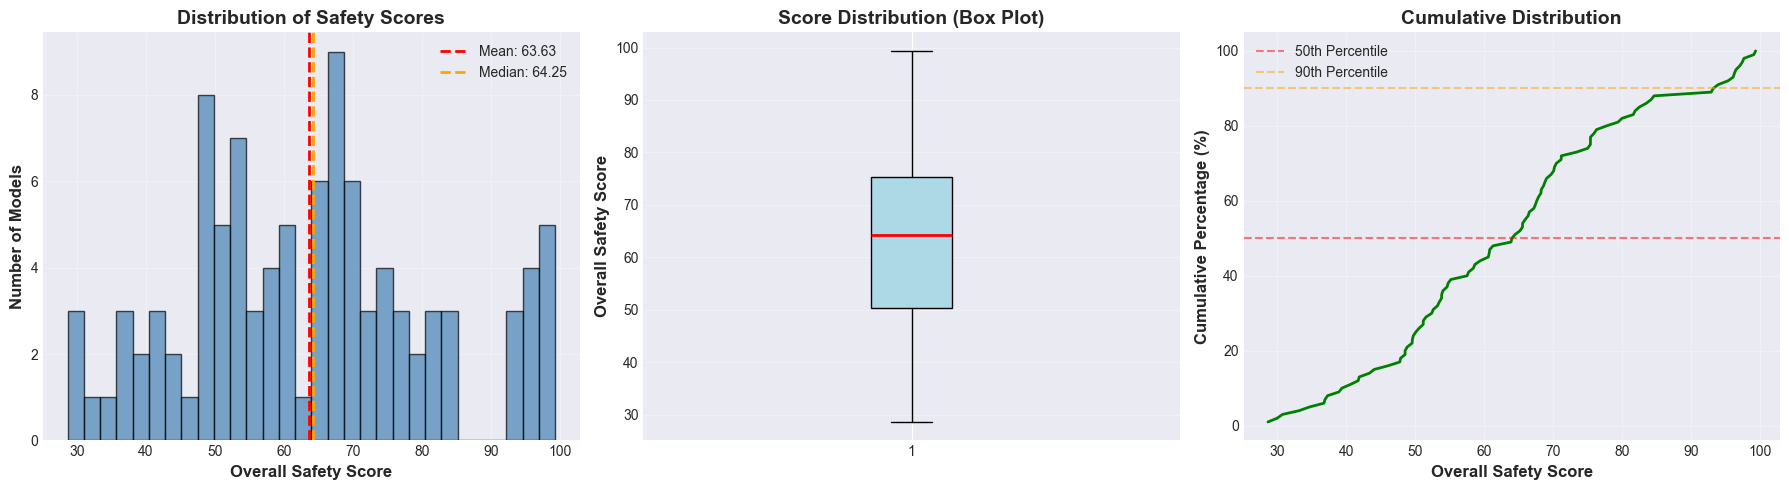

📊 SAFETY SCORE STATISTICS
   Mean: 63.63
   Median: 64.25
   Std Dev: 18.00
   Min: 28.65
   Max: 99.36


In [96]:
# Overall Score Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df['Overall_Score'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df['Overall_Score'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {df["Overall_Score"].mean():.2f}')
axes[0].axvline(df['Overall_Score'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {df["Overall_Score"].median():.2f}')
axes[0].set_xlabel('Overall Safety Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Models', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Safety Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
bp = axes[1].boxplot(df['Overall_Score'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_edgecolor('black')
bp['medians'][0].set_color('red')
bp['medians'][0].set_linewidth(2)
axes[1].set_ylabel('Overall Safety Score', fontsize=12, fontweight='bold')
axes[1].set_title('Score Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Cumulative distribution
sorted_scores = np.sort(df['Overall_Score'])
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores) * 100
axes[2].plot(sorted_scores, cumulative, linewidth=2, color='green')
axes[2].axhline(50, color='red', linestyle='--', alpha=0.5, label='50th Percentile')
axes[2].axhline(90, color='orange', linestyle='--', alpha=0.5, label='90th Percentile')
axes[2].set_xlabel('Overall Safety Score', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
axes[2].set_title('Cumulative Distribution', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 SAFETY SCORE STATISTICS")
print(f"   Mean: {df['Overall_Score'].mean():.2f}")
print(f"   Median: {df['Overall_Score'].median():.2f}")
print(f"   Std Dev: {df['Overall_Score'].std():.2f}")
print(f"   Min: {df['Overall_Score'].min():.2f}")
print(f"   Max: {df['Overall_Score'].max():.2f}")

### 📏 Does Model Size Affect Safety?

**Hypothesis**: Larger models might have better safety due to more sophisticated training and alignment.

Let's investigate the relationship between model size (in billions of parameters) and safety scores.

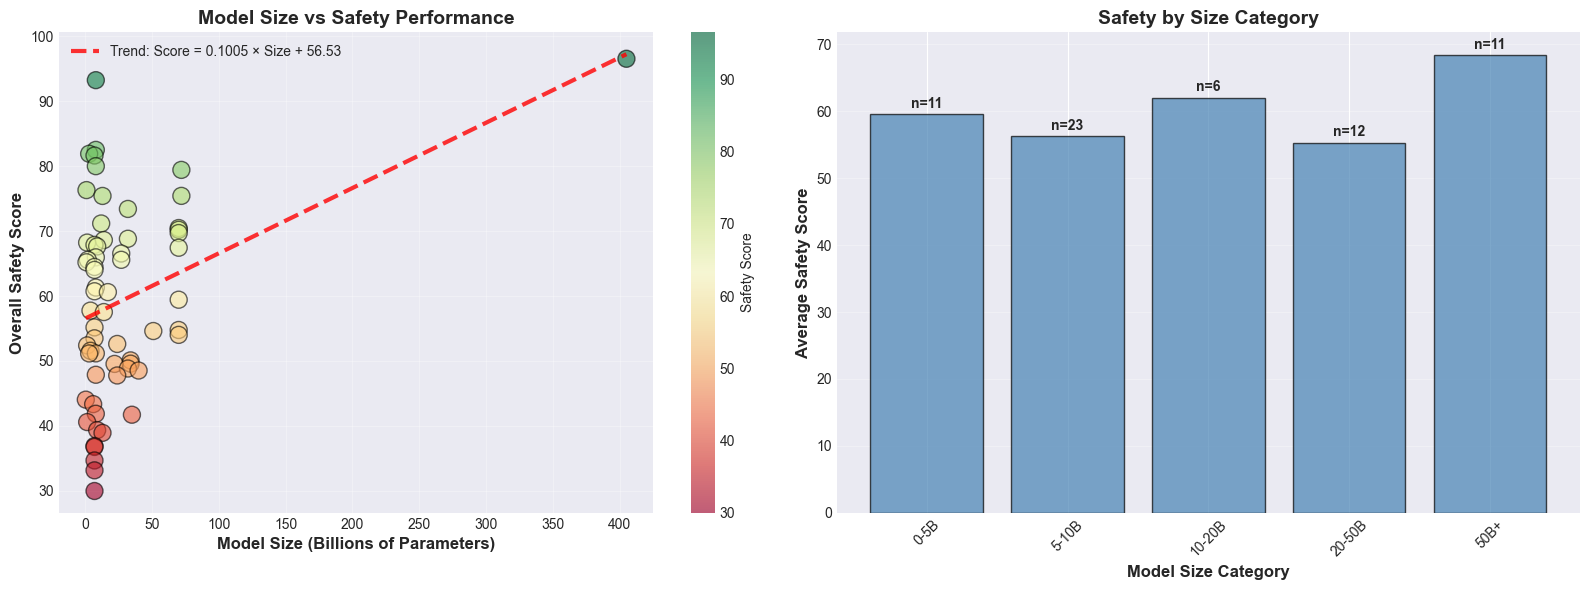


📈 CORRELATION ANALYSIS
   Pearson Correlation: 0.3613
   Interpretation: moderate positive correlation

💡 Insight: Larger models tend to be safer


In [97]:
# Model Size vs Safety Score Analysis
df_with_size = df[df['Model_Size_Numeric'].notna()].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot with trend line
scatter = axes[0].scatter(df_with_size['Model_Size_Numeric'], 
                         df_with_size['Overall_Score'],
                         c=df_with_size['Overall_Score'], cmap='RdYlGn',
                         s=150, alpha=0.6, edgecolors='black', linewidth=1)
                         
# Add trend line
z = np.polyfit(df_with_size['Model_Size_Numeric'], df_with_size['Overall_Score'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_with_size['Model_Size_Numeric'].min(), 
                      df_with_size['Model_Size_Numeric'].max(), 100)
axes[0].plot(x_trend, p(x_trend), "r--", linewidth=3, alpha=0.8,
            label=f'Trend: Score = {z[0]:.4f} × Size + {z[1]:.2f}')

axes[0].set_xlabel('Model Size (Billions of Parameters)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Overall Safety Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Size vs Safety Performance', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Safety Score')

# Size categories analysis
size_bins = [0, 5, 10, 20, 50, 500]
size_labels = ['0-5B', '5-10B', '10-20B', '20-50B', '50B+']
df_with_size['Size_Category'] = pd.cut(df_with_size['Model_Size_Numeric'], 
                                        bins=size_bins, labels=size_labels)

size_stats = df_with_size.groupby('Size_Category')['Overall_Score'].agg(['mean', 'count'])
axes[1].bar(range(len(size_stats)), size_stats['mean'], 
           color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(size_stats)))
axes[1].set_xticklabels(size_stats.index, rotation=45)
axes[1].set_ylabel('Average Safety Score', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Model Size Category', fontsize=12, fontweight='bold')
axes[1].set_title('Safety by Size Category', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (mean, count) in enumerate(zip(size_stats['mean'], size_stats['count'])):
    axes[1].text(i, mean + 1, f'n={int(count)}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate correlation
corr = df_with_size['Model_Size_Numeric'].corr(df_with_size['Overall_Score'])
print(f"\n📈 CORRELATION ANALYSIS")
print(f"   Pearson Correlation: {corr:.4f}")
if abs(corr) < 0.3:
    strength = "weak"
elif abs(corr) < 0.7:
    strength = "moderate"
else:
    strength = "strong"
direction = "positive" if corr > 0 else "negative"
print(f"   Interpretation: {strength} {direction} correlation")
print(f"\n💡 Insight: {'Larger models tend to be safer' if corr > 0 else 'Size does not strongly predict safety'}")

### 📅 Are Newer Models Safer?

**Hypothesis**: As AI safety research progresses, newer models should demonstrate improved safety characteristics.

Let's analyze the temporal trend in AI safety.

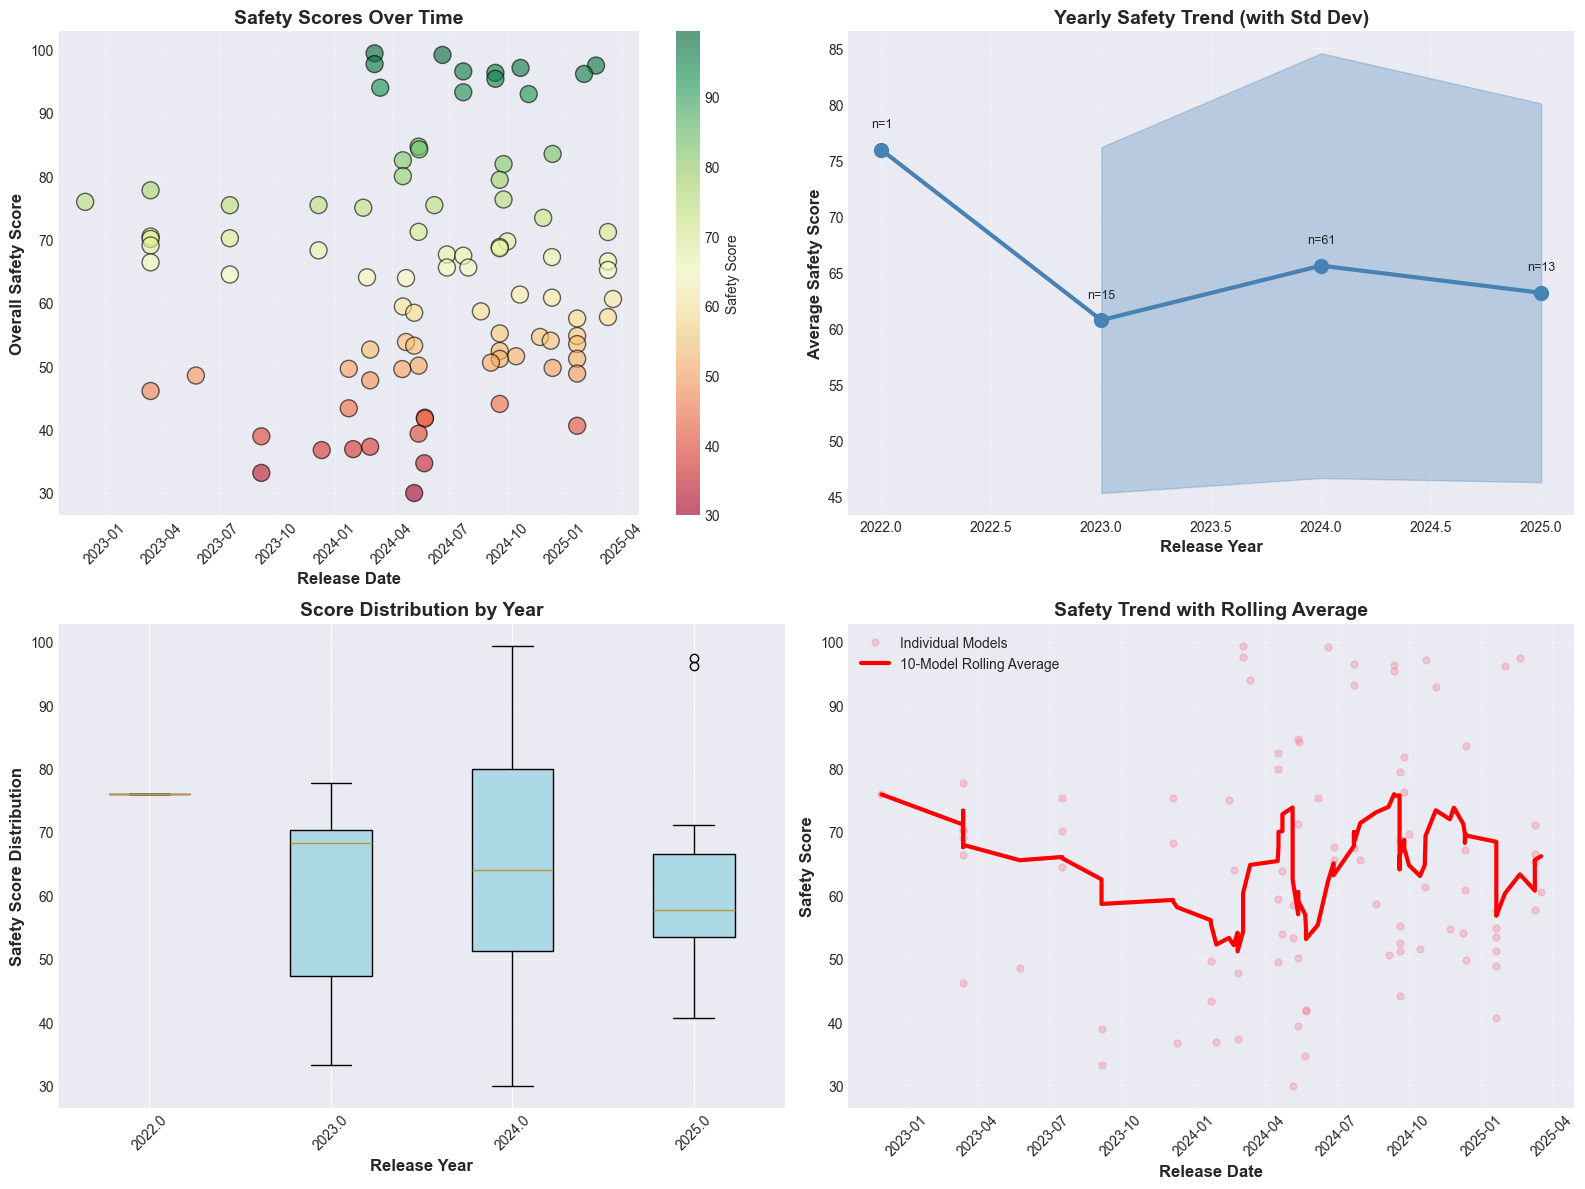


📈 TEMPORAL CORRELATION ANALYSIS
   Correlation with Time: 0.0735
   Yearly Average Improvement: -3.19 points/year

💡 Insight: No clear temporal trend in safety


In [98]:
# Release Date vs Safety Score Analysis
df_with_date = df[df['Release_Date'].notna()].copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time series scatter plot
scatter = axes[0, 0].scatter(df_with_date['Release_Date'], 
                            df_with_date['Overall_Score'],
                            c=df_with_date['Overall_Score'], cmap='RdYlGn',
                            s=150, alpha=0.6, edgecolors='black', linewidth=1)
axes[0, 0].set_xlabel('Release Date', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Overall Safety Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Safety Scores Over Time', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)
plt.colorbar(scatter, ax=axes[0, 0], label='Safety Score')

# Yearly average trend
yearly_stats = df_with_date.groupby('Release_Year')['Overall_Score'].agg(['mean', 'std', 'count'])
axes[0, 1].plot(yearly_stats.index, yearly_stats['mean'], 
               marker='o', linewidth=3, markersize=10, color='steelblue')
axes[0, 1].fill_between(yearly_stats.index, 
                        yearly_stats['mean'] - yearly_stats['std'],
                        yearly_stats['mean'] + yearly_stats['std'],
                        alpha=0.3, color='steelblue')
axes[0, 1].set_xlabel('Release Year', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Safety Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Yearly Safety Trend (with Std Dev)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Add count labels
for year, mean, count in zip(yearly_stats.index, yearly_stats['mean'], yearly_stats['count']):
    axes[0, 1].text(year, mean + 2, f'n={int(count)}', ha='center', fontsize=9)

# Box plot by year
years_to_plot = sorted(df_with_date['Release_Year'].dropna().unique())
data_by_year = [df_with_date[df_with_date['Release_Year'] == year]['Overall_Score'].values 
                for year in years_to_plot]
bp = axes[1, 0].boxplot(data_by_year, labels=years_to_plot, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('black')
axes[1, 0].set_xlabel('Release Year', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Safety Score Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Score Distribution by Year', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)

# Rolling average (3-month window)
df_sorted = df_with_date.sort_values('Release_Date')
df_sorted['Rolling_Mean'] = df_sorted['Overall_Score'].rolling(window=10, min_periods=1).mean()
axes[1, 1].plot(df_sorted['Release_Date'], df_sorted['Overall_Score'], 
               'o', alpha=0.3, label='Individual Models', markersize=5)
axes[1, 1].plot(df_sorted['Release_Date'], df_sorted['Rolling_Mean'],
               linewidth=3, color='red', label='10-Model Rolling Average')
axes[1, 1].set_xlabel('Release Date', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Safety Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Safety Trend with Rolling Average', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlation analysis
df_date_clean = df_with_date[df_with_date['Days_Since_2020'].notna()]
corr_time = df_date_clean['Days_Since_2020'].corr(df_date_clean['Overall_Score'])

print(f"\n📈 TEMPORAL CORRELATION ANALYSIS")
print(f"   Correlation with Time: {corr_time:.4f}")
print(f"   Yearly Average Improvement: {(yearly_stats['mean'].iloc[-1] - yearly_stats['mean'].iloc[0]) / len(yearly_stats):.2f} points/year")
print(f"\n💡 Insight: {'Safety is improving over time' if corr_time > 0.1 else 'No clear temporal trend in safety'}")

### 🎯 Attack Method Effectiveness Analysis

Not all attacks are equally effective. Let's identify which jailbreaking methods pose the greatest threat to AI safety.

**Lower scores = More effective attack** (model failed to resist)

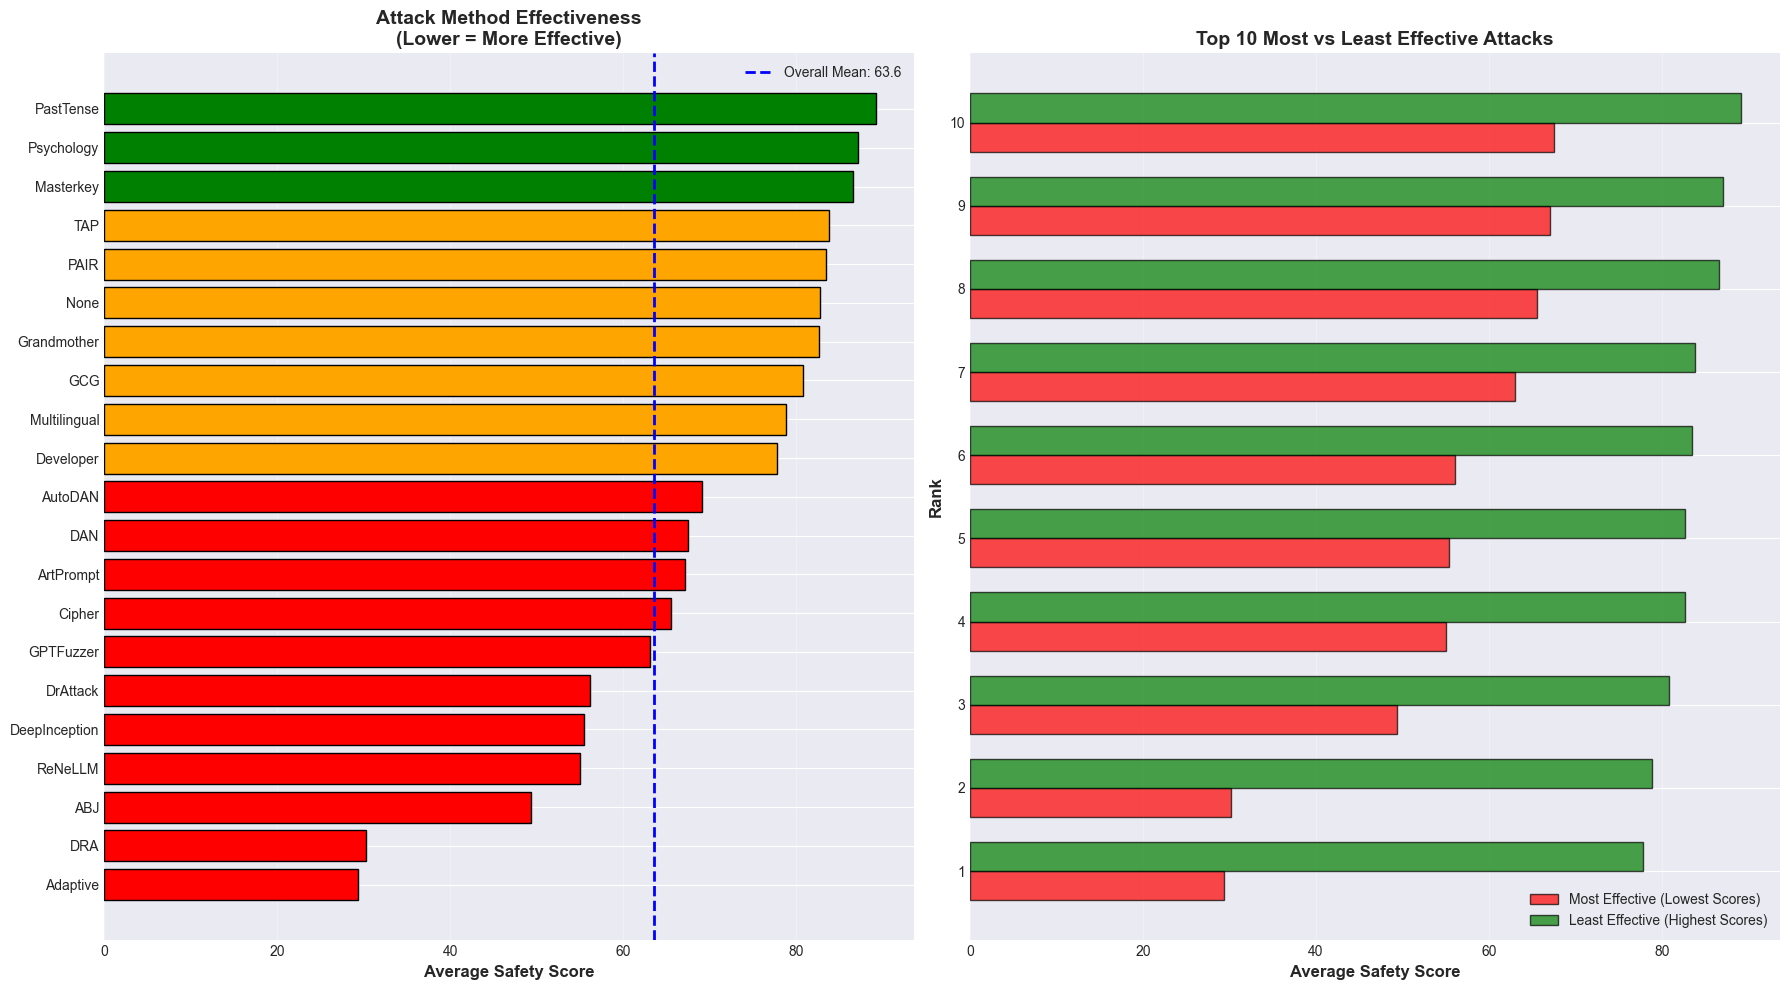

🔴 TOP 5 MOST EFFECTIVE ATTACKS (Biggest Threats)
1. Adaptive             - Avg Score: 29.35
2. DRA                  - Avg Score: 30.21
3. ABJ                  - Avg Score: 49.38
4. ReNeLLM              - Avg Score: 55.03
5. DeepInception        - Avg Score: 55.45

🟢 TOP 5 LEAST EFFECTIVE ATTACKS (Best Defended)
1. PAIR                 - Avg Score: 83.45
2. TAP                  - Avg Score: 83.87
3. Masterkey            - Avg Score: 86.60
4. Psychology           - Avg Score: 87.14
5. PastTense            - Avg Score: 89.22


In [99]:
# Attack Method Performance Analysis
attack_score_cols = [f'{method}_Score' for method in attack_methods]
attack_means = df[attack_score_cols].mean().sort_values()

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Horizontal bar chart
colors = ['red' if score < 70 else 'orange' if score < 85 else 'green' 
          for score in attack_means.values]
axes[0].barh(range(len(attack_means)), attack_means.values, color=colors, edgecolor='black')
axes[0].set_yticks(range(len(attack_means)))
axes[0].set_yticklabels([label.replace('_Score', '') for label in attack_means.index])
axes[0].set_xlabel('Average Safety Score', fontsize=12, fontweight='bold')
axes[0].set_title('Attack Method Effectiveness\n(Lower = More Effective)', 
                  fontsize=14, fontweight='bold')
axes[0].axvline(df['Overall_Score'].mean(), color='blue', linestyle='--', 
               linewidth=2, label=f'Overall Mean: {df["Overall_Score"].mean():.1f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Top 10 most/least effective
top_10_effective = attack_means.head(10)
top_10_resistant = attack_means.tail(10)

x_pos = np.arange(10)
width = 0.35

axes[1].barh(x_pos - width/2, top_10_effective.values, width, 
            label='Most Effective (Lowest Scores)', color='red', alpha=0.7, edgecolor='black')
axes[1].barh(x_pos + width/2, top_10_resistant.values, width,
            label='Least Effective (Highest Scores)', color='green', alpha=0.7, edgecolor='black')
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels([f"{i+1}" for i in range(10)])
axes[1].set_xlabel('Average Safety Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Rank', fontsize=12, fontweight='bold')
axes[1].set_title('Top 10 Most vs Least Effective Attacks', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("=" * 80)
print("🔴 TOP 5 MOST EFFECTIVE ATTACKS (Biggest Threats)")
print("=" * 80)
for i, (method, score) in enumerate(attack_means.head(5).items(), 1):
    method_name = method.replace('_Score', '')
    print(f"{i}. {method_name:20s} - Avg Score: {score:.2f}")

print("\n" + "=" * 80)
print("🟢 TOP 5 LEAST EFFECTIVE ATTACKS (Best Defended)")
print("=" * 80)
for i, (method, score) in enumerate(attack_means.tail(5).items(), 1):
    method_name = method.replace('_Score', '')
    print(f"{i}. {method_name:20s} - Avg Score: {score:.2f}")

## 4️⃣ Radar Plots - Comprehensive Model Visualization

Radar plots provide a multi-dimensional view of model performance across different attack methods. This helps identify:
- **Overall robustness patterns**
- **Specific vulnerabilities**
- **Comparative strengths between models**

We'll create radar plots for ALL models in the dataset, organized by their overall safety ranking.

In [100]:
# Radar Plot Function
def create_radar_chart(model_data, model_name, attack_methods_list, ax, color='steelblue'):
    """
    Create a radar chart for a single model showing performance across attack methods.
    
    Parameters:
    - model_data: Series containing the model's scores
    - model_name: Name of the model
    - attack_methods_list: List of attack methods to plot
    - ax: Matplotlib axis (must be polar projection)
    - color: Color for the plot
    """
    num_vars = len(attack_methods_list)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * math.pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the circle
    
    # Get scores for each attack method
    scores = []
    for method in attack_methods_list:
        score = model_data.get(f'{method}_Score', 0)
        scores.append(score if not pd.isna(score) else 0)
    scores += scores[:1]  # Complete the circle
    
    # Plot
    ax.plot(angles, scores, 'o-', linewidth=2, color=color, markersize=4)
    ax.fill(angles, scores, alpha=0.25, color=color)
    
    # Customize
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attack_methods_list, size=7)
    ax.set_ylim(0, 100)
    ax.set_yticks([25, 50, 75, 100])
    ax.set_yticklabels(['25', '50', '75', '100'], size=7, color='gray')
    ax.grid(True, linewidth=0.5, alpha=0.5)
    
    # Title with overall score
    overall_score = model_data.get('Overall_Score', 0)
    ax.set_title(f"{model_name}\nOverall: {overall_score:.1f}", 
                size=9, fontweight='bold', pad=15)
    
    return ax

# Select attack methods for radar plots (choose 8 diverse methods)
selected_radar_methods = ['None', 'ABJ', 'GCG', 'PAIR', 'TAP', 'DAN', 'Cipher', 'AutoDAN']

print("=" * 80)
print("GENERATING RADAR PLOTS FOR ALL MODELS")
print("=" * 80)
print(f"Selected Attack Methods: {', '.join(selected_radar_methods)}")
print(f"Total Models to Plot: {len(df)}")
print("\nThis may take a moment...")

GENERATING RADAR PLOTS FOR ALL MODELS
Selected Attack Methods: None, ABJ, GCG, PAIR, TAP, DAN, Cipher, AutoDAN
Total Models to Plot: 100

This may take a moment...


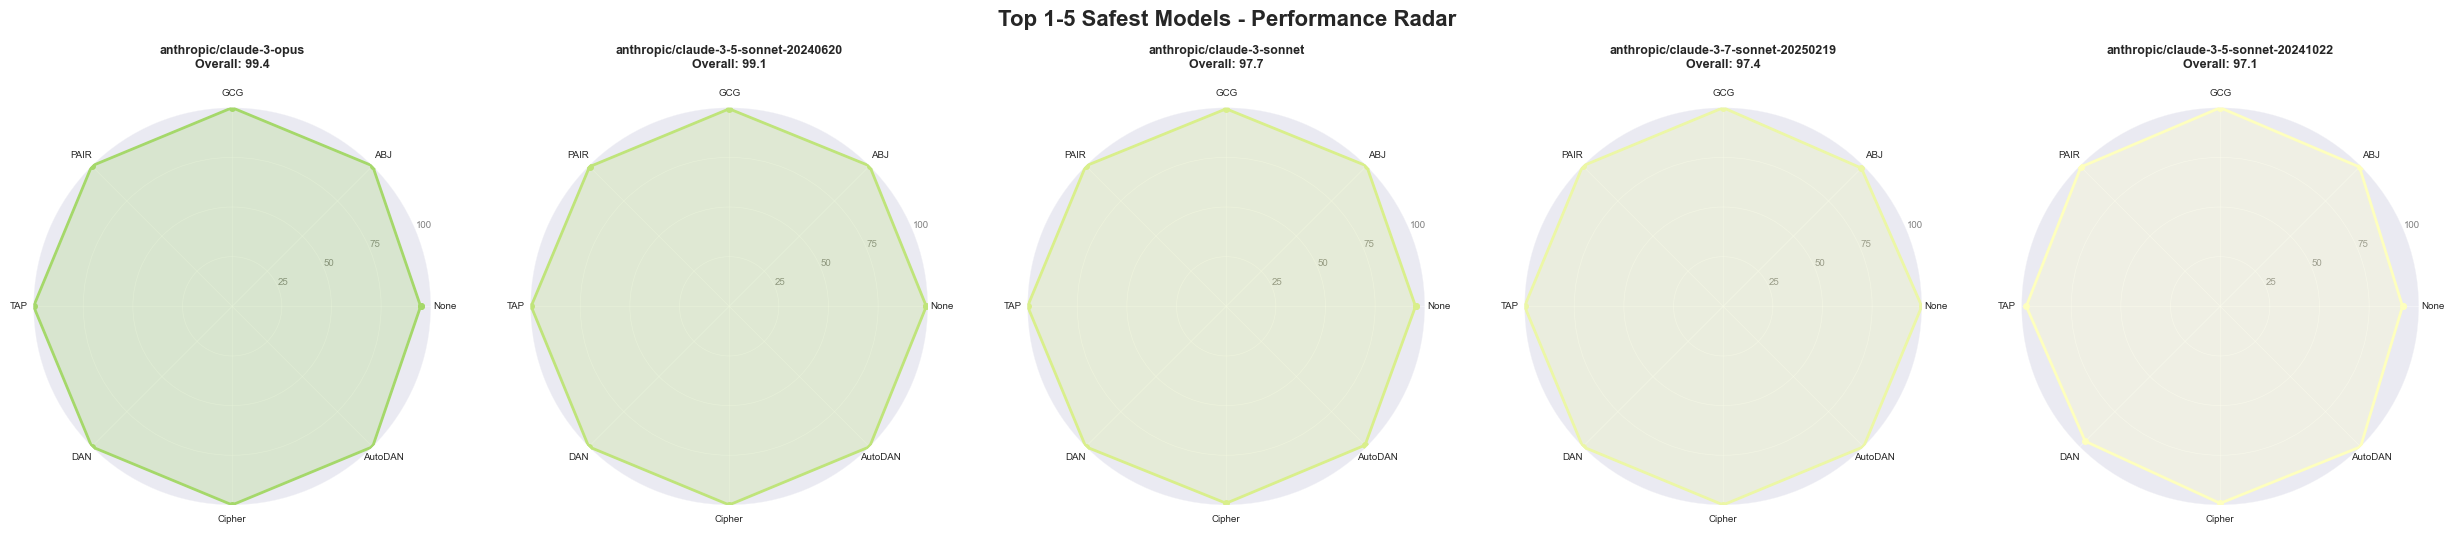

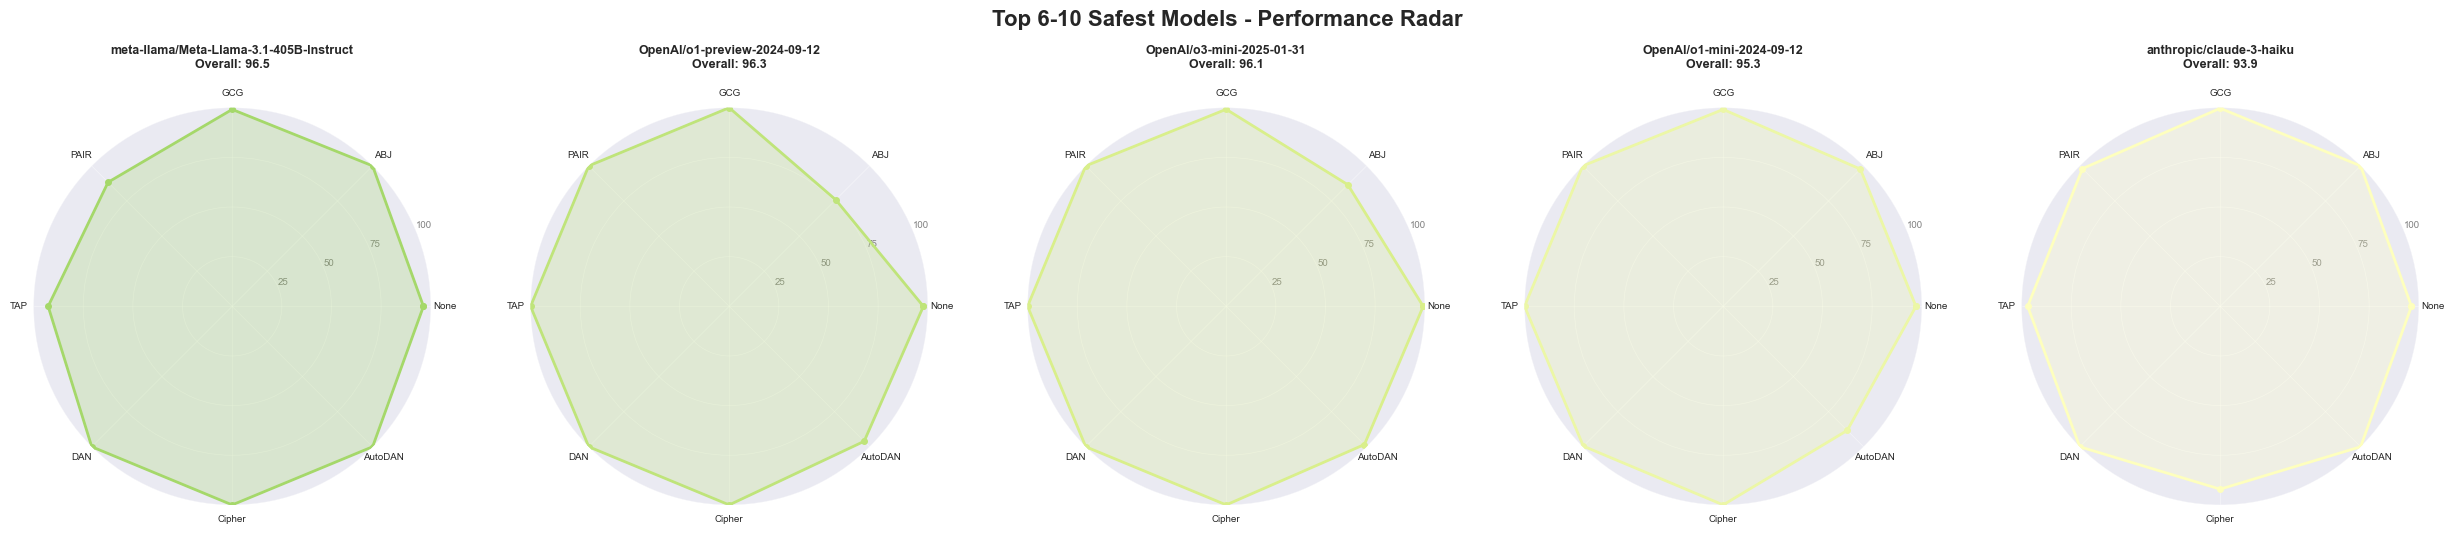

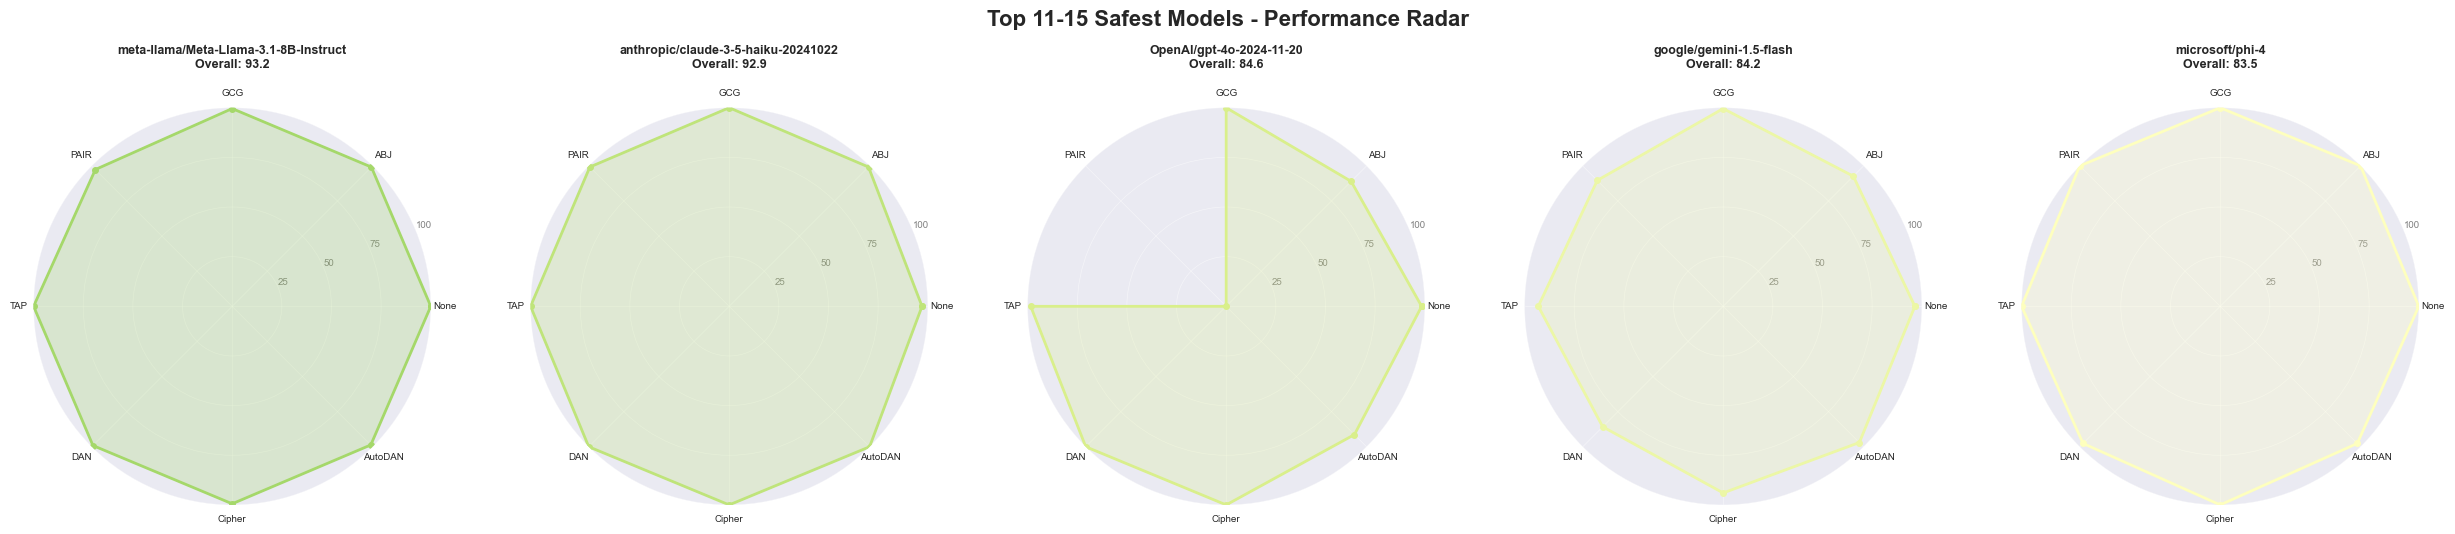

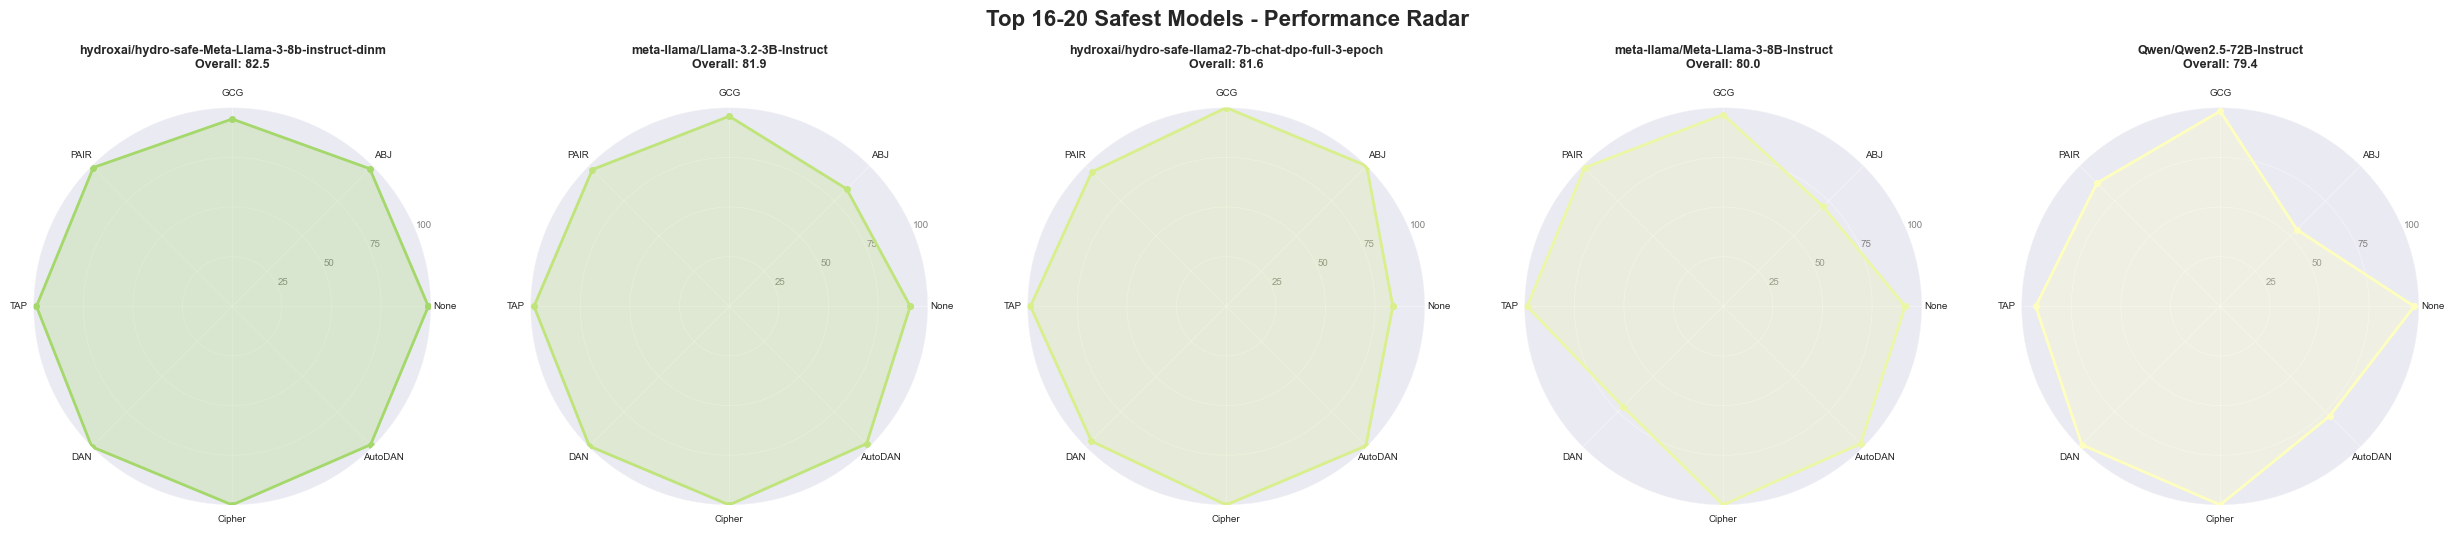


✅ Radar plots for top 20 models generated!


In [101]:
# Create radar plots for TOP 20 models
top_20_models = df.nlargest(20, 'Overall_Score')

# Create 4 figures with 5 models each
for fig_num in range(4):
    start_idx = fig_num * 5
    end_idx = start_idx + 5
    models_subset = top_20_models.iloc[start_idx:end_idx]
    
    if len(models_subset) == 0:
        break
    
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), subplot_kw=dict(projection='polar'))
    
    # Color gradient from green (best) to yellow
    colors = plt.cm.RdYlGn(np.linspace(0.7, 0.5, 5))
    
    for idx, (_, model_row) in enumerate(models_subset.iterrows()):
        if idx < len(axes):
            create_radar_chart(model_row, model_row['Model'], 
                             selected_radar_methods, axes[idx], color=colors[idx])
    
    # Hide unused subplots
    for idx in range(len(models_subset), 5):
        axes[idx].axis('off')
    
    plt.suptitle(f'Top {start_idx+1}-{start_idx+len(models_subset)} Safest Models - Performance Radar', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("\n✅ Radar plots for top 20 models generated!")

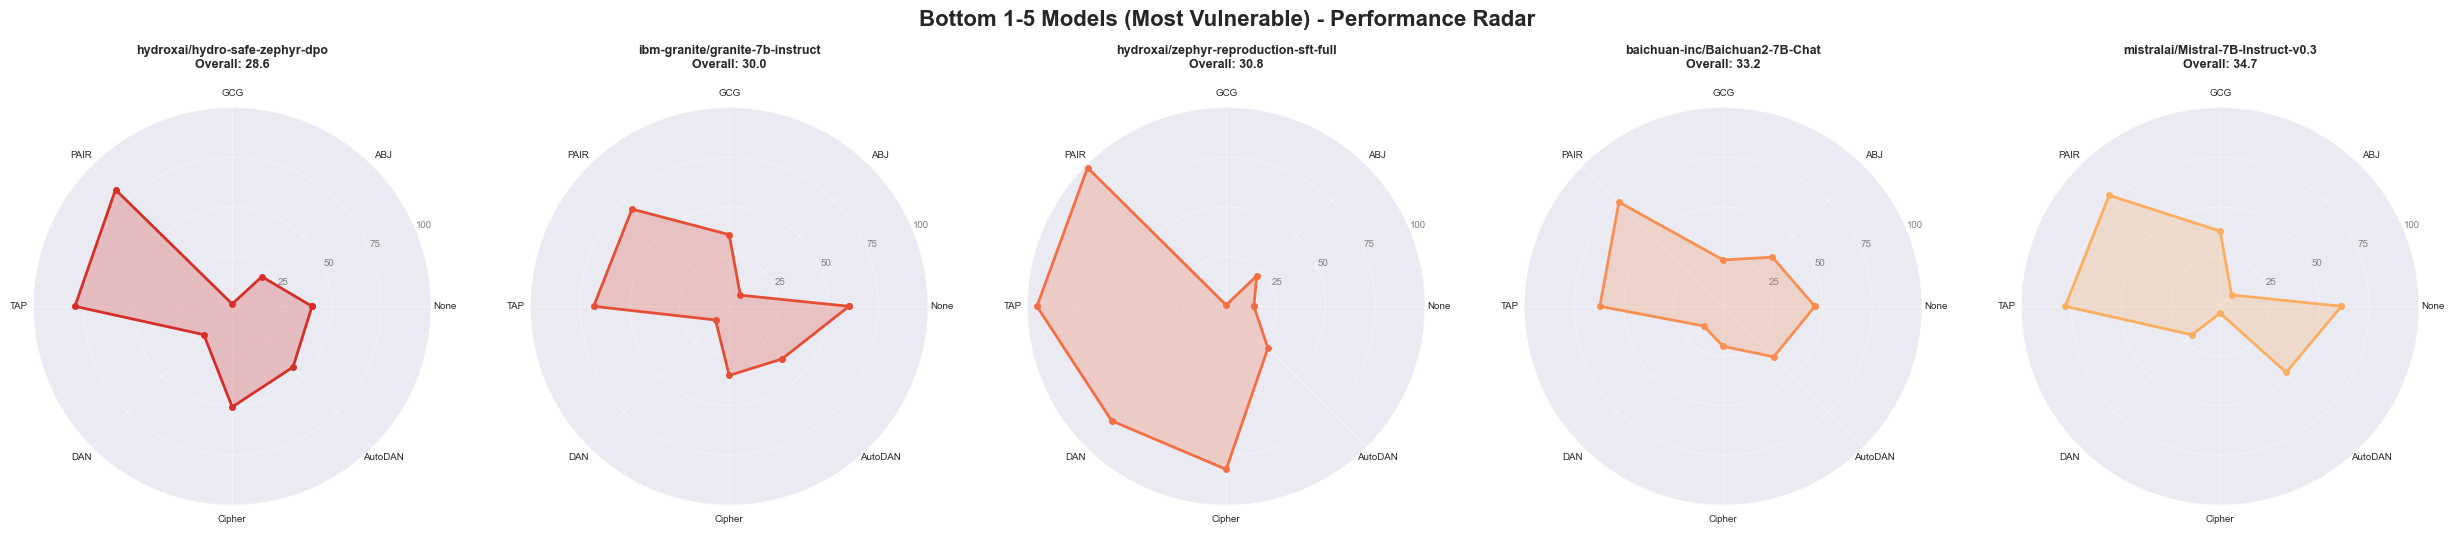

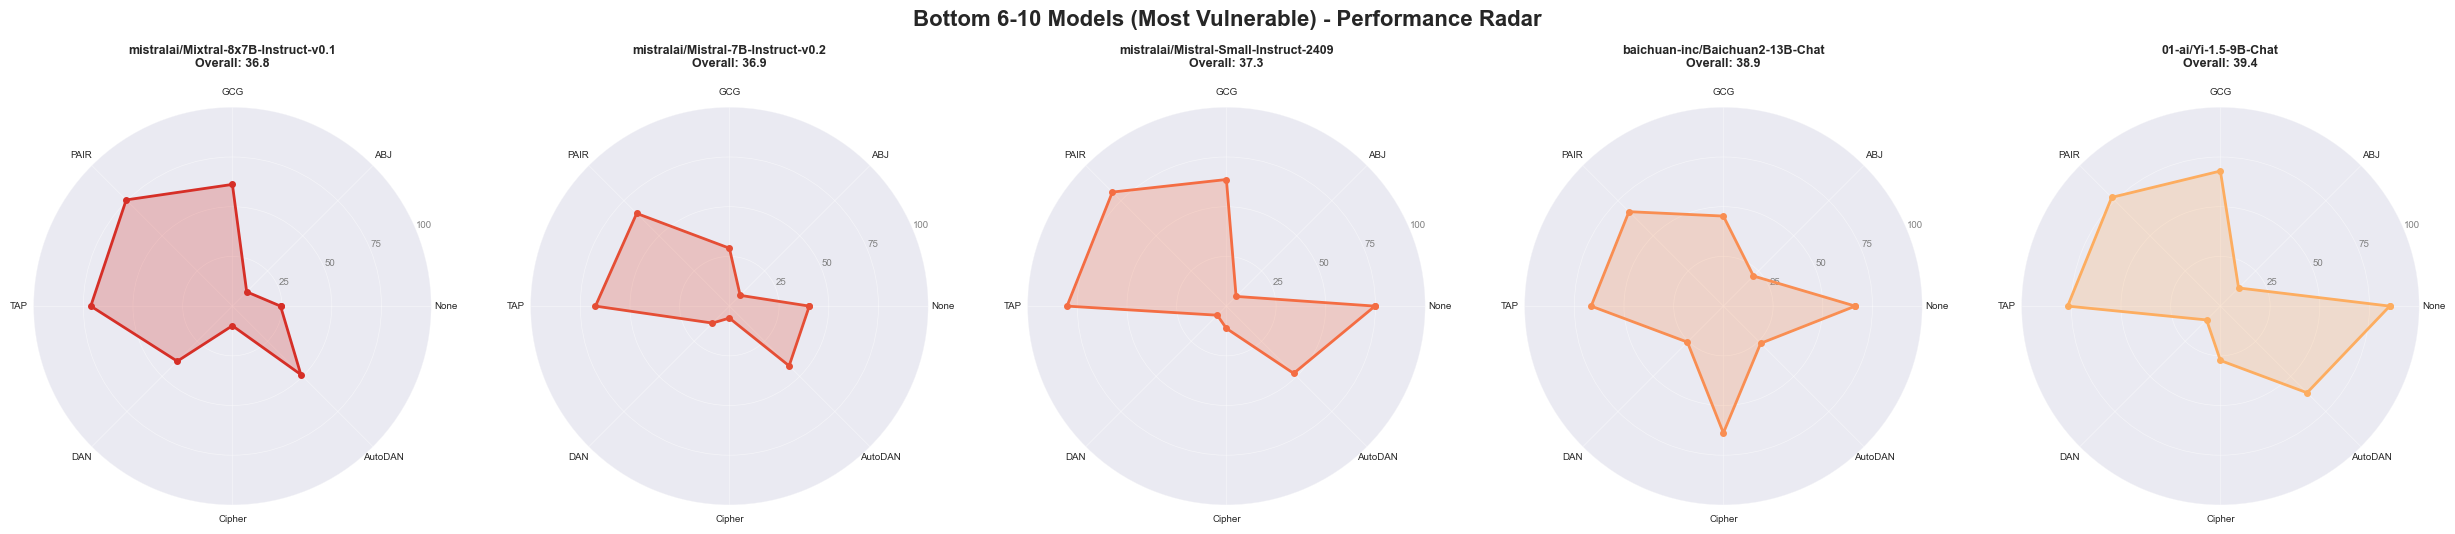

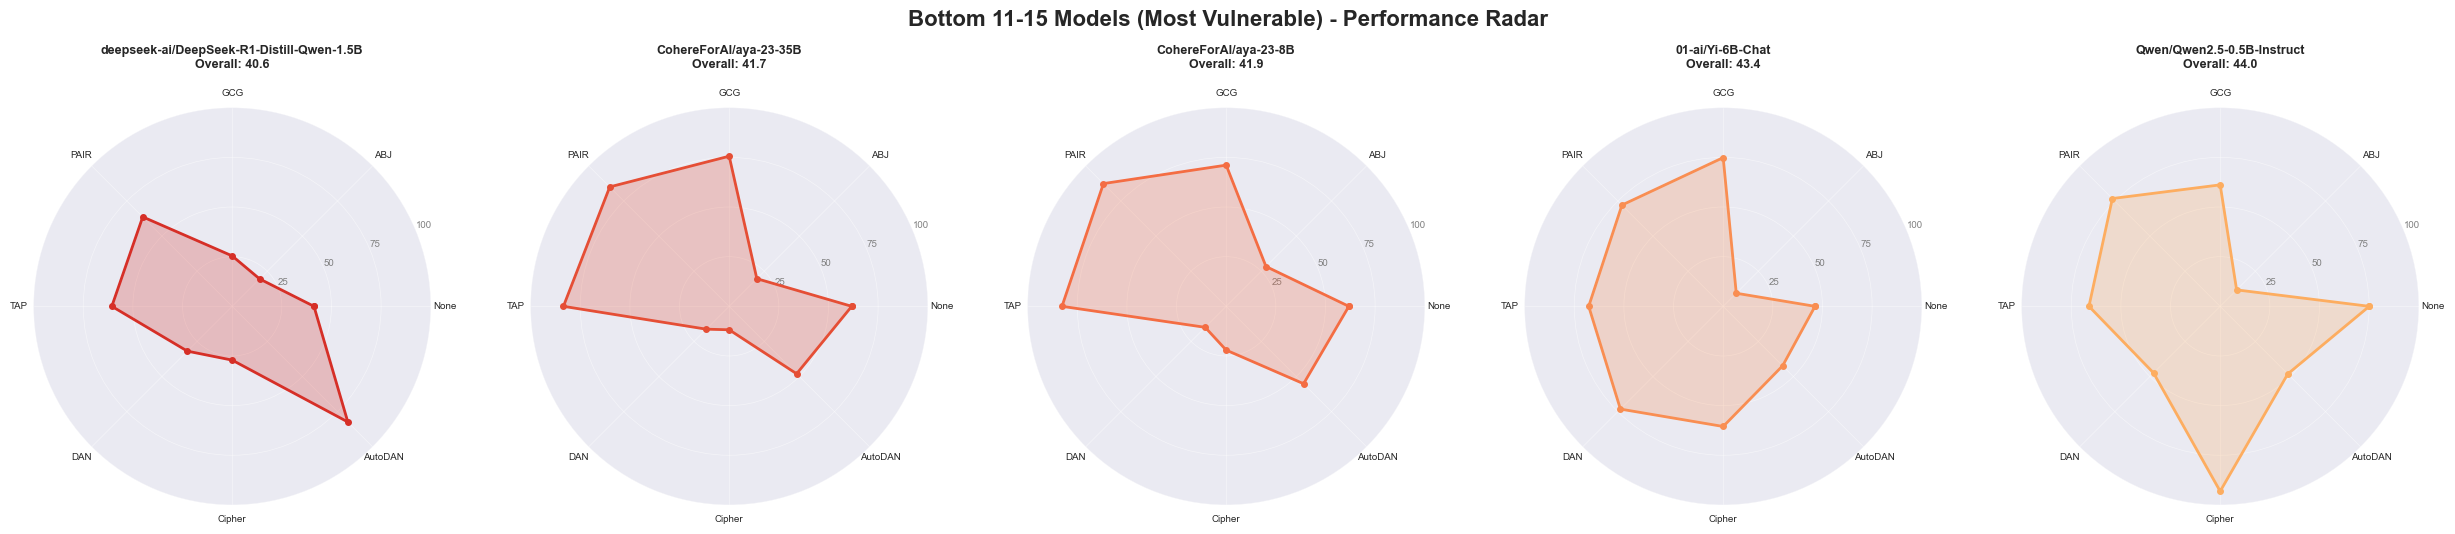

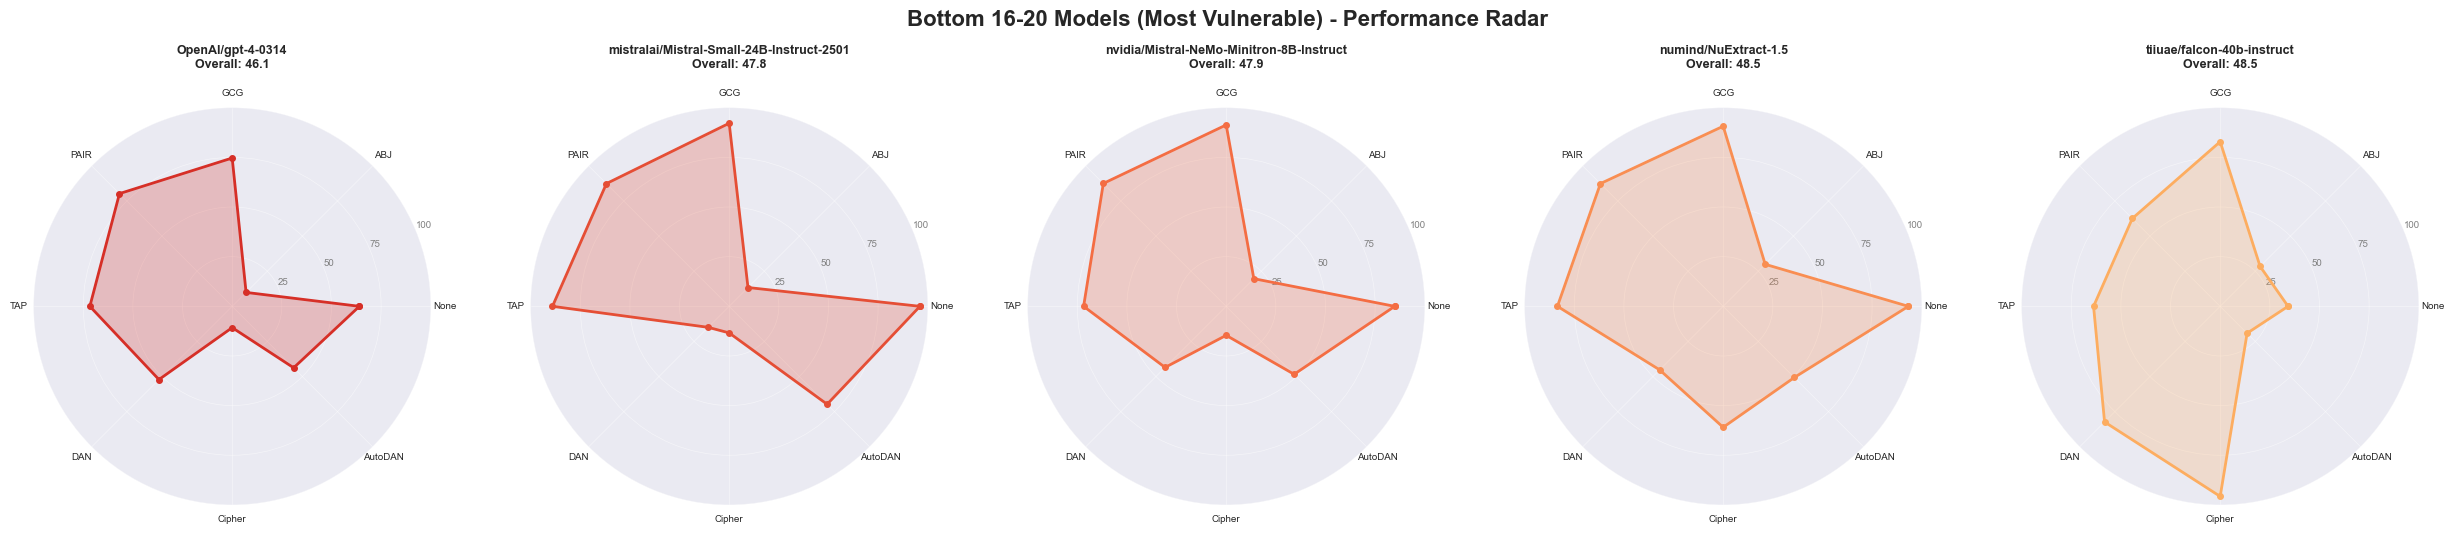


✅ Radar plots for bottom 20 models generated!


In [102]:
# Create radar plots for BOTTOM 20 models (most vulnerable)
bottom_20_models = df.nsmallest(20, 'Overall_Score')

for fig_num in range(4):
    start_idx = fig_num * 5
    end_idx = start_idx + 5
    models_subset = bottom_20_models.iloc[start_idx:end_idx]
    
    if len(models_subset) == 0:
        break
    
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), subplot_kw=dict(projection='polar'))
    
    # Color gradient from red (worst) to orange
    colors = plt.cm.RdYlGn(np.linspace(0.1, 0.3, 5))
    
    for idx, (_, model_row) in enumerate(models_subset.iterrows()):
        if idx < len(axes):
            create_radar_chart(model_row, model_row['Model'], 
                             selected_radar_methods, axes[idx], color=colors[idx])
    
    # Hide unused subplots
    for idx in range(len(models_subset), 5):
        axes[idx].axis('off')
    
    plt.suptitle(f'Bottom {start_idx+1}-{start_idx+len(models_subset)} Models (Most Vulnerable) - Performance Radar', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("\n✅ Radar plots for bottom 20 models generated!")

## 5️⃣ Provider Analysis

Different AI companies have different approaches to safety. Let's analyze performance by provider to identify best practices and patterns.

PROVIDER SAFETY RANKINGS

Top 10 Providers by Average Safety Score:
             Overall_Score_mean  Overall_Score_std  Overall_Score_min  \
Provider                                                                
anthropic                 96.78               2.46              92.93   
OpenAI                    77.17              15.32              46.09   
meta-llama                73.29              13.19              54.02   
google                    68.17               6.63              57.75   
microsoft                 64.96              13.02              53.82   
Qwen                      63.16              12.60              44.05   
hydroxai                  57.99              21.92              28.65   
nvidia                    55.94               9.57              47.88   
deepseek-ai               52.07               5.32              40.60   
01-ai                     45.60               5.17              39.36   

             Overall_Score_max  Overall_Score_count  Mo

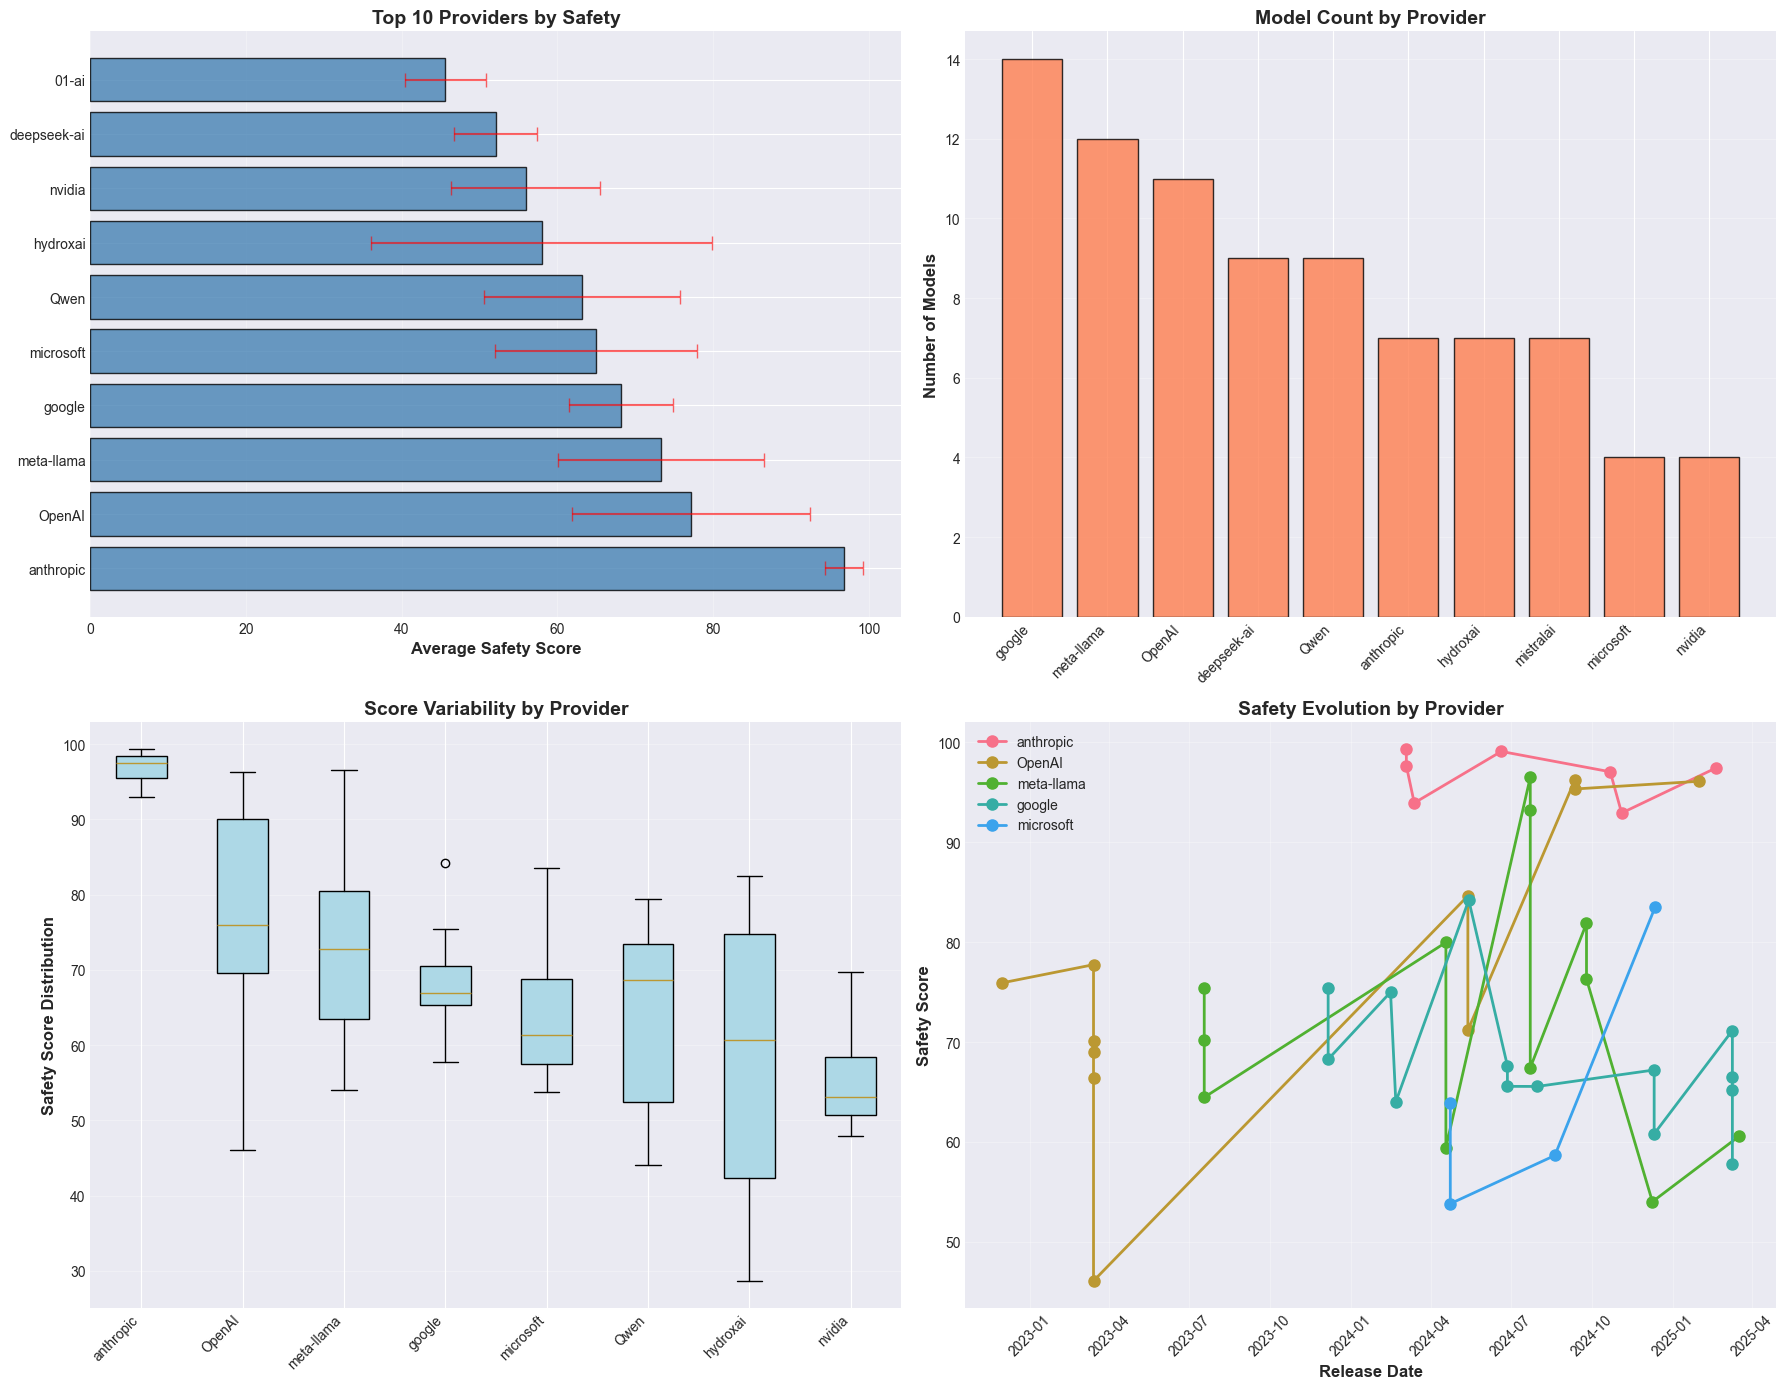

In [103]:
# Provider Statistics
provider_stats = df.groupby('Provider').agg({
    'Overall_Score': ['mean', 'std', 'min', 'max', 'count'],
    'Model_Size_Numeric': 'mean'
}).round(2)

provider_stats.columns = ['_'.join(col).strip() for col in provider_stats.columns.values]
provider_stats = provider_stats.sort_values('Overall_Score_mean', ascending=False)

# Filter major providers (3+ models)
major_providers = provider_stats[provider_stats['Overall_Score_count'] >= 3]

print("=" * 80)
print("PROVIDER SAFETY RANKINGS")
print("=" * 80)
print(f"\nTop 10 Providers by Average Safety Score:")
print(major_providers.head(10))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Top providers by average score
top_10_providers = major_providers.head(10)
axes[0, 0].barh(range(len(top_10_providers)), top_10_providers['Overall_Score_mean'],
               color='steelblue', edgecolor='black', alpha=0.8)
axes[0, 0].set_yticks(range(len(top_10_providers)))
axes[0, 0].set_yticklabels(top_10_providers.index)
axes[0, 0].set_xlabel('Average Safety Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Top 10 Providers by Safety', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Add error bars for std dev
for i, (idx, row) in enumerate(top_10_providers.iterrows()):
    axes[0, 0].errorbar(row['Overall_Score_mean'], i, 
                       xerr=row['Overall_Score_std'], 
                       fmt='none', color='red', capsize=5, alpha=0.6)

# 2. Model count by provider
model_counts = df['Provider'].value_counts().head(10)
axes[0, 1].bar(range(len(model_counts)), model_counts.values,
              color='coral', edgecolor='black', alpha=0.8)
axes[0, 1].set_xticks(range(len(model_counts)))
axes[0, 1].set_xticklabels(model_counts.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Models', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Model Count by Provider', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Score distribution boxplot
providers_to_plot = major_providers.head(8).index.tolist()
data_by_provider = [df[df['Provider'] == p]['Overall_Score'].values for p in providers_to_plot]
bp = axes[1, 0].boxplot(data_by_provider, labels=providers_to_plot, patch_artist=True)
for patch, provider in zip(bp['boxes'], providers_to_plot):
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('black')
axes[1, 0].set_xticklabels(providers_to_plot, rotation=45, ha='right')
axes[1, 0].set_ylabel('Safety Score Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Score Variability by Provider', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Safety trends over time for top providers
top_5_providers = major_providers.head(5).index.tolist()
for provider in top_5_providers:
    df_prov = df[(df['Provider'] == provider) & (df['Release_Date'].notna())]
    if len(df_prov) > 1:
        df_prov_sorted = df_prov.sort_values('Release_Date')
        axes[1, 1].plot(df_prov_sorted['Release_Date'], 
                       df_prov_sorted['Overall_Score'],
                       marker='o', label=provider, linewidth=2, markersize=8)

axes[1, 1].set_xlabel('Release Date', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Safety Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Safety Evolution by Provider', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6️⃣ Forecasting Models - Predicting Safety Scores

Now we build machine learning models to predict safety scores using:
- **Input Features**: Model Size (billions of parameters) + Release Date (days since 2020)
- **Target**: Overall Safety Score (0-100)

### Why This Matters:
- Helps anticipate safety of future models
- Identifies which factors most influence safety
- Enables proactive safety planning

We'll train and compare 5 different regression models.

In [104]:
# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Prepare data - use only models with both size and date
df_model = df[(df['Model_Size_Numeric'].notna()) & (df['Days_Since_2020'].notna())].copy()

print("=" * 80)
print("FORECASTING MODEL PREPARATION")
print("=" * 80)
print(f"✅ Models available for training: {len(df_model)}")
print(f"📊 Features: Model Size (B), Days Since 2020")
print(f"🎯 Target: Overall Safety Score")
print(f"\nFeature Ranges:")
print(f"  - Model Size: {df_model['Model_Size_Numeric'].min():.1f}B to {df_model['Model_Size_Numeric'].max():.1f}B")
print(f"  - Days Since 2020: {df_model['Days_Since_2020'].min():.0f} to {df_model['Days_Since_2020'].max():.0f}")
print(f"  - Safety Score: {df_model['Overall_Score'].min():.1f} to {df_model['Overall_Score'].max():.1f}")

FORECASTING MODEL PREPARATION
✅ Models available for training: 57
📊 Features: Model Size (B), Days Since 2020
🎯 Target: Overall Safety Score

Feature Ranges:
  - Model Size: 0.5B to 405.0B
  - Days Since 2020: 1168 to 1903
  - Safety Score: 30.0 to 96.5


In [105]:
# Prepare features and target
X = df_model[['Model_Size_Numeric', 'Days_Since_2020']].values
y = df_model['Overall_Score'].values

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n📊 DATA SPLIT")
print(f"  Training set: {len(X_train)} models ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test)} models ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n✅ Feature scaling applied (StandardScaler)")


📊 DATA SPLIT
  Training set: 45 models (78.9%)
  Test set: 12 models (21.1%)

✅ Feature scaling applied (StandardScaler)


In [106]:
# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=3)
}

results = {}

print("=" * 80)
print("TRAINING FORECASTING MODELS")
print("=" * 80)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Evaluate
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                                scoring='r2', n_jobs=-1)
    
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test
    }
    
    print(f"  ✅ Train R²: {train_r2:.4f}")
    print(f"  ✅ Test R²: {test_r2:.4f}")
    print(f"  ✅ Test RMSE: {test_rmse:.4f}")
    print(f"  ✅ Test MAE: {test_mae:.4f}")
    print(f"  ✅ CV R² (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
print(f"\n{'=' * 80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Test R² = {results[best_model_name]['test_r2']:.4f}")
print(f"   Test RMSE = {results[best_model_name]['test_rmse']:.4f}")
print(f"{'=' * 80}")

TRAINING FORECASTING MODELS

🔄 Training Linear Regression...
  ✅ Train R²: 0.0391
  ✅ Test R²: 0.4773
  ✅ Test RMSE: 12.8354
  ✅ Test MAE: 11.0361
  ✅ CV R² (5-fold): -0.1984 ± 0.2870

🔄 Training Ridge Regression...
  ✅ Train R²: 0.0390
  ✅ Test R²: 0.4783
  ✅ Test RMSE: 12.8233
  ✅ Test MAE: 10.9602
  ✅ CV R² (5-fold): -0.1939 ± 0.2791

🔄 Training Lasso Regression...
  ✅ Train R²: 0.0389
  ✅ Test R²: 0.4784
  ✅ Test RMSE: 12.8219
  ✅ Test MAE: 10.8814
  ✅ CV R² (5-fold): -0.1962 ± 0.2761

🔄 Training Random Forest...
  ✅ Train R²: 0.8432
  ✅ Test R²: 0.2744
  ✅ Test RMSE: 15.1228
  ✅ Test MAE: 12.1340
  ✅ CV R² (5-fold): 0.1026 ± 0.1770

🔄 Training Gradient Boosting...
  ✅ Train R²: 0.9864
  ✅ Test R²: 0.2169
  ✅ Test RMSE: 15.7110
  ✅ Test MAE: 12.0622
  ✅ CV R² (5-fold): -0.0425 ± 0.2307

🏆 BEST MODEL: Lasso Regression
   Test R² = 0.4784
   Test RMSE = 12.8219


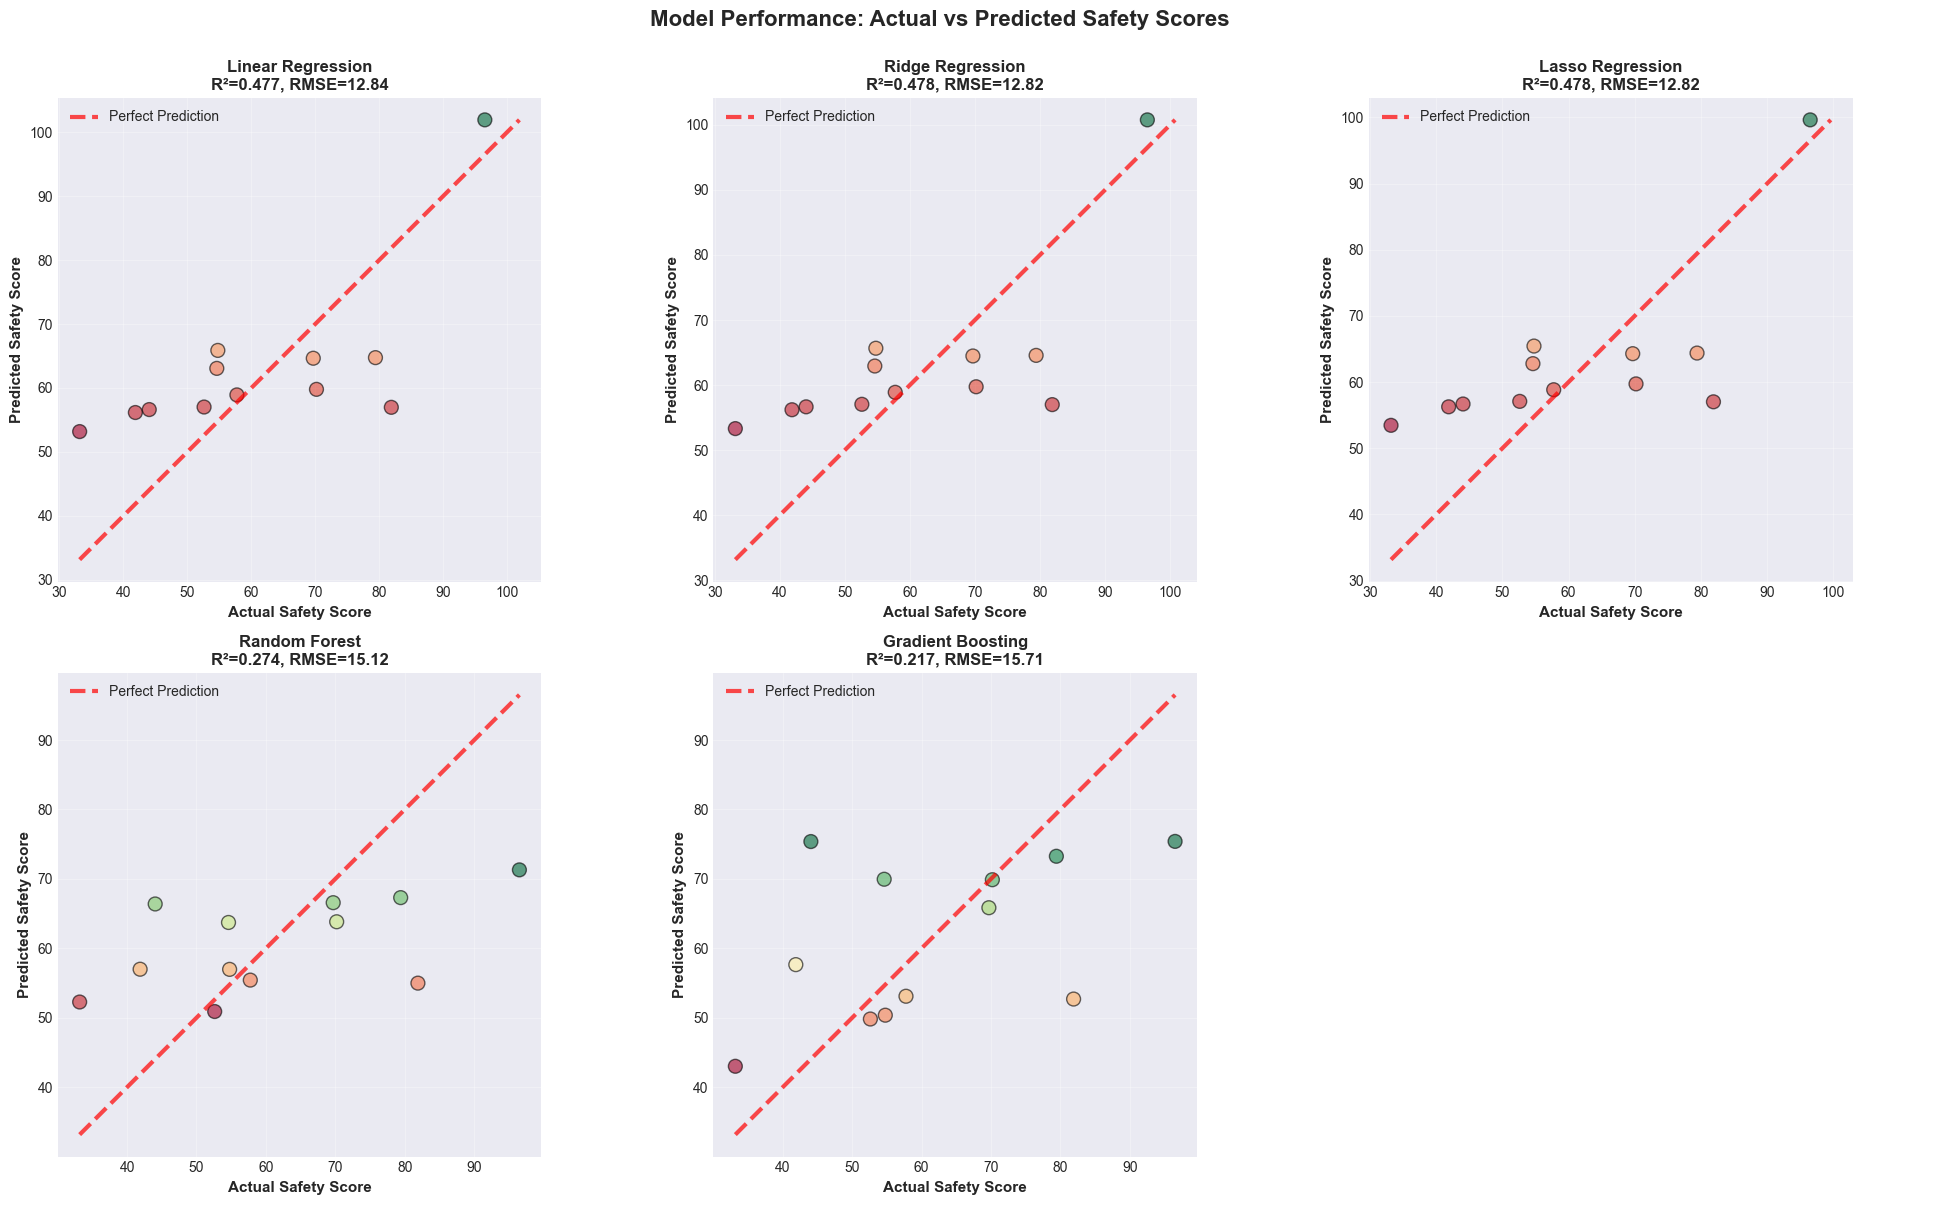

In [107]:
# Visualize model performance
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    
    # Scatter plot: Actual vs Predicted
    ax.scatter(y_test, result['predictions'], alpha=0.6, s=100, 
              edgecolors='black', linewidth=1, c=result['predictions'], cmap='RdYlGn')
    
    # Perfect prediction line
    min_val = min(y_test.min(), result['predictions'].min())
    max_val = max(y_test.max(), result['predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 
           'r--', lw=3, label='Perfect Prediction', alpha=0.7)
    
    # Formatting
    ax.set_xlabel('Actual Safety Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Safety Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nR²={result["test_r2"]:.3f}, RMSE={result["test_rmse"]:.2f}', 
                fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Hide last subplot if we have fewer than 6 models
if len(results) < 6:
    axes[-1].axis('off')

plt.suptitle('Model Performance: Actual vs Predicted Safety Scores', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

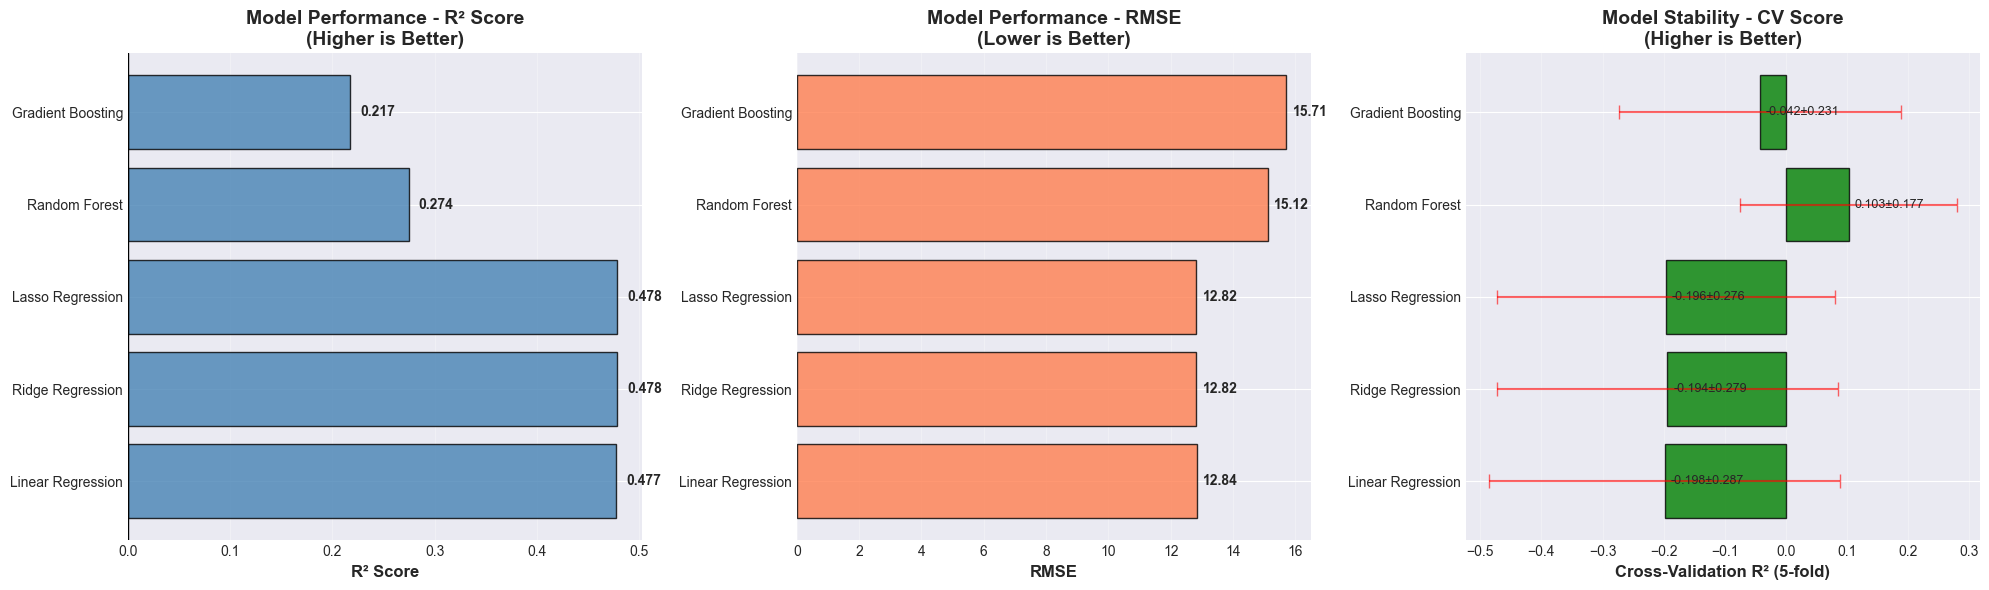


💡 INTERPRETATION:
   The Lasso Regression provides the best balance of accuracy and generalization.


In [108]:
# Model comparison visualization
model_names = list(results.keys())
test_r2_scores = [results[m]['test_r2'] for m in model_names]
test_rmse_scores = [results[m]['test_rmse'] for m in model_names]
cv_means = [results[m]['cv_mean'] for m in model_names]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# R² comparison
axes[0].barh(model_names, test_r2_scores, color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance - R² Score\n(Higher is Better)', 
                 fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].axvline(0, color='black', linewidth=1)

# Add value labels
for i, score in enumerate(test_r2_scores):
    axes[0].text(score + 0.01, i, f'{score:.3f}', va='center', fontweight='bold')

# RMSE comparison
axes[1].barh(model_names, test_rmse_scores, color='coral', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[1].set_title('Model Performance - RMSE\n(Lower is Better)', 
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, score in enumerate(test_rmse_scores):
    axes[1].text(score + 0.2, i, f'{score:.2f}', va='center', fontweight='bold')

# Cross-validation comparison
axes[2].barh(model_names, cv_means, color='green', edgecolor='black', alpha=0.8)
axes[2].set_xlabel('Cross-Validation R² (5-fold)', fontsize=12, fontweight='bold')
axes[2].set_title('Model Stability - CV Score\n(Higher is Better)', 
                 fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')

# Add error bars
for i, (mean, name) in enumerate(zip(cv_means, model_names)):
    std = results[name]['cv_std']
    axes[2].errorbar(mean, i, xerr=std, fmt='none', color='red', capsize=5, alpha=0.6)
    axes[2].text(mean + 0.01, i, f'{mean:.3f}±{std:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n💡 INTERPRETATION:")
print(f"   The {best_model_name} provides the best balance of accuracy and generalization.")

## 7️⃣ Provider-Specific Forecasting Models

Different providers may have different relationships between model characteristics and safety. Let's build provider-specific models to capture these nuances.

This enables:
- **Provider-specific predictions**
- **Understanding provider safety strategies**
- **Identifying which factors matter most for each provider**

In [109]:
# Provider-specific forecasting
provider_forecasting_results = {}
major_providers_list = major_providers.head(10).index.tolist()

print("=" * 80)
print("PROVIDER-SPECIFIC FORECASTING MODELS")
print("=" * 80)

for provider in major_providers_list:
    df_prov = df_model[df_model['Provider'] == provider].copy()
    
    if len(df_prov) < 5:  # Need minimum samples
        continue
    
    X_prov = df_prov[['Model_Size_Numeric', 'Days_Since_2020']].values
    y_prov = df_prov['Overall_Score'].values
    
    # Scale features
    scaler_prov = StandardScaler()
    X_prov_scaled = scaler_prov.fit_transform(X_prov)
    
    # Train Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_prov_scaled, y_prov)
    
    # Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=3)
    rf_model.fit(X_prov_scaled, y_prov)
    
    # Evaluate (training R² since limited data)
    y_pred_lr = lr_model.predict(X_prov_scaled)
    y_pred_rf = rf_model.predict(X_prov_scaled)
    
    r2_lr = r2_score(y_prov, y_pred_lr)
    r2_rf = r2_score(y_prov, y_pred_rf)
    
    # Extract feature importance
    size_coef = lr_model.coef_[0]
    date_coef = lr_model.coef_[1]
    
    provider_forecasting_results[provider] = {
        'n_models': len(df_prov),
        'linear_r2': r2_lr,
        'rf_r2': r2_rf,
        'size_coefficient': size_coef,
        'date_coefficient': date_coef,
        'avg_score': y_prov.mean(),
        'linear_model': lr_model,
        'rf_model': rf_model,
        'scaler': scaler_prov
    }
    
    print(f"\n{provider}:")
    print(f"  Models: {len(df_prov)}")
    print(f"  Avg Score: {y_prov.mean():.2f}")
    print(f"  Linear R²: {r2_lr:.4f}")
    print(f"  Size Impact: {size_coef:.4f} (positive = larger is safer)")
    print(f"  Date Impact: {date_coef:.4f} (positive = newer is safer)")

print(f"\n✅ Created models for {len(provider_forecasting_results)} providers")

PROVIDER-SPECIFIC FORECASTING MODELS

meta-llama:
  Models: 12
  Avg Score: 73.29
  Linear R²: 0.1603
  Size Impact: 5.0712 (positive = larger is safer)
  Date Impact: -0.7213 (positive = newer is safer)

google:
  Models: 8
  Avg Score: 65.43
  Linear R²: 0.0887
  Size Impact: 1.0498 (positive = larger is safer)
  Date Impact: -0.0854 (positive = newer is safer)

Qwen:
  Models: 9
  Avg Score: 63.16
  Linear R²: 0.8356
  Size Impact: 11.9266 (positive = larger is safer)
  Date Impact: 3.6450 (positive = newer is safer)

deepseek-ai:
  Models: 6
  Avg Score: 51.07
  Linear R²: 0.1352
  Size Impact: 1.9911 (positive = larger is safer)
  Date Impact: 0.0000 (positive = newer is safer)

✅ Created models for 4 providers


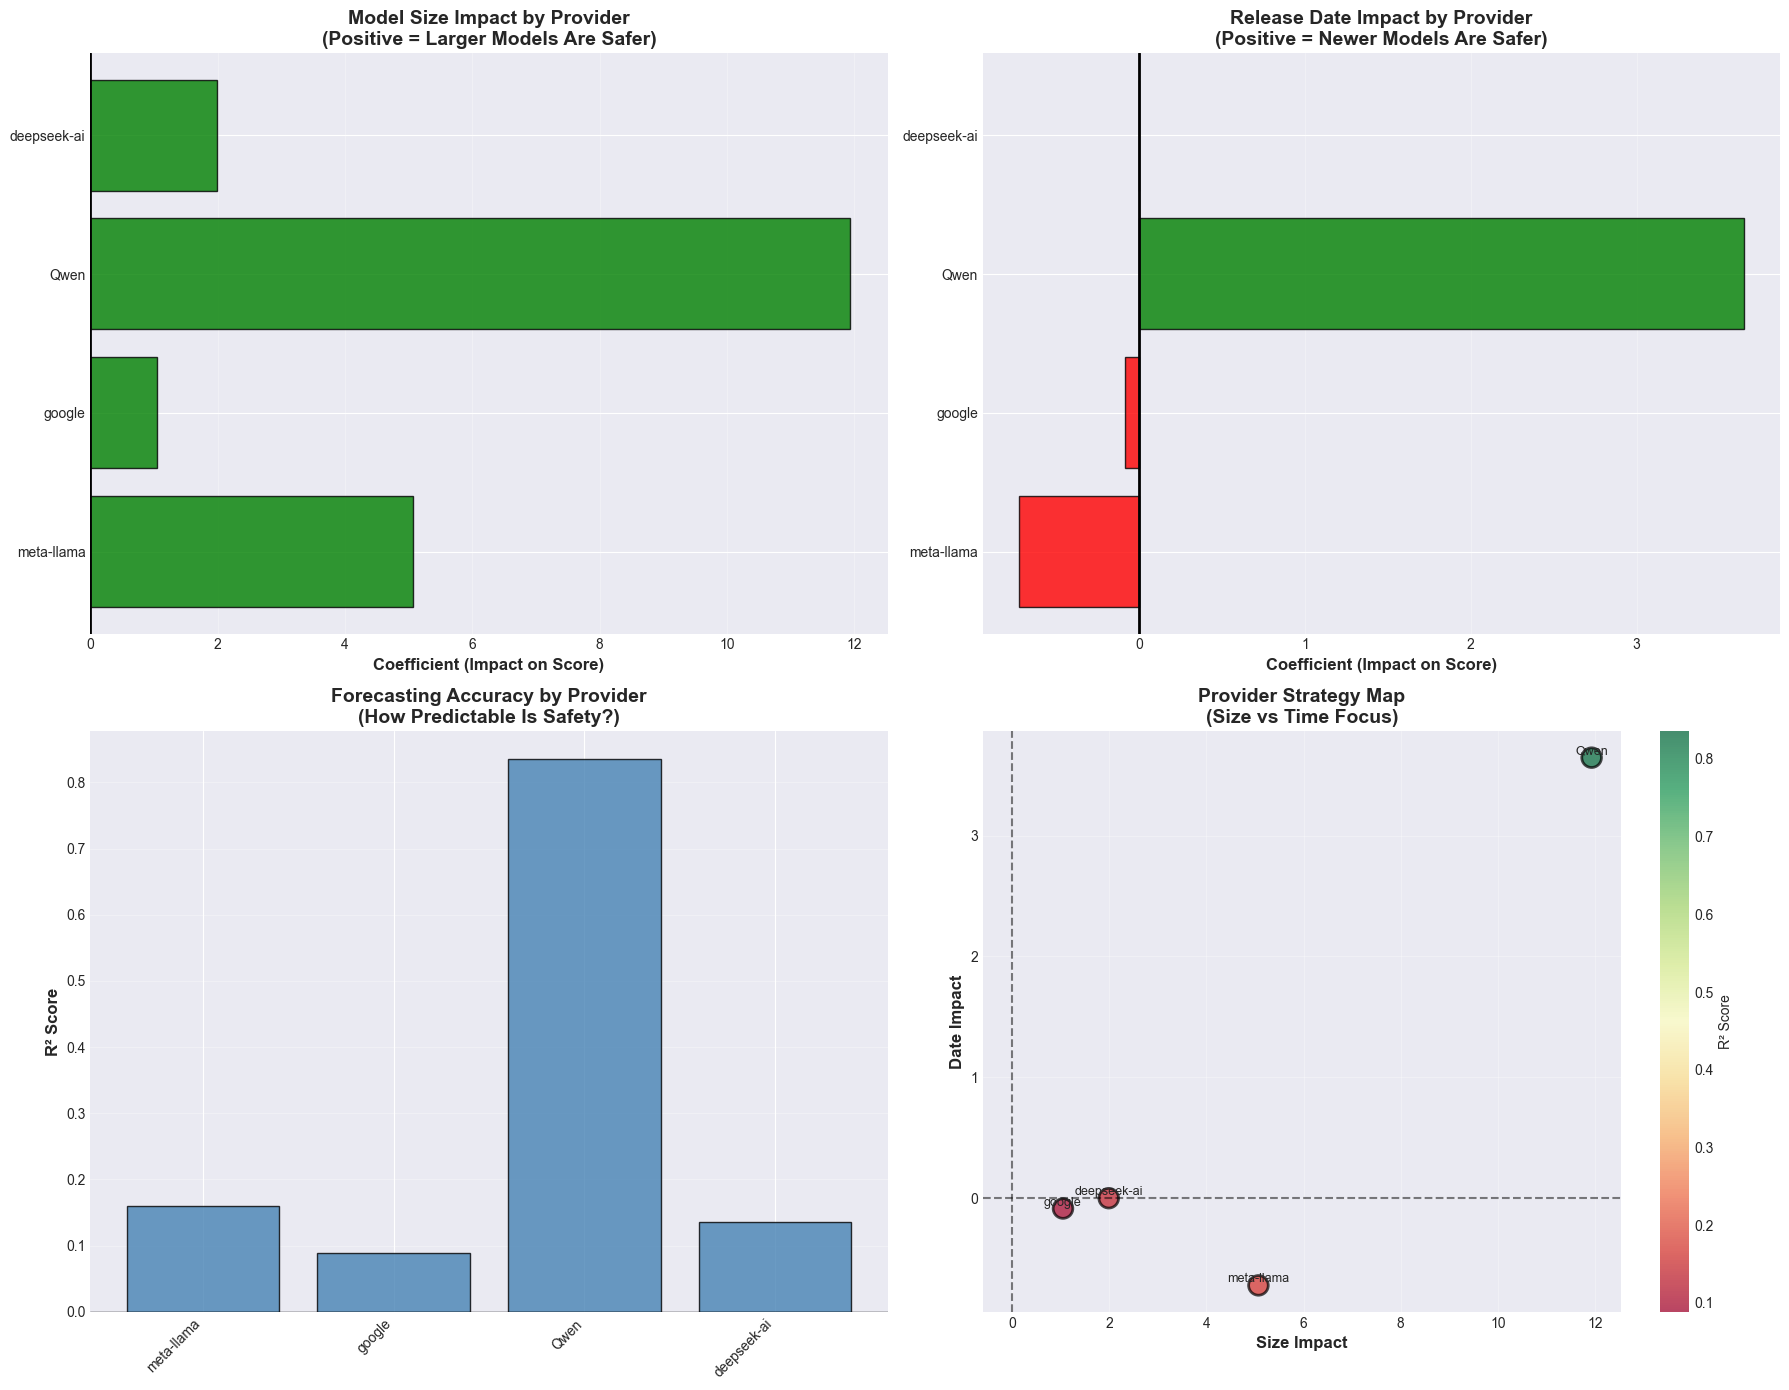

In [110]:
# Visualize provider-specific insights
providers_list = list(provider_forecasting_results.keys())
size_impacts = [provider_forecasting_results[p]['size_coefficient'] for p in providers_list]
date_impacts = [provider_forecasting_results[p]['date_coefficient'] for p in providers_list]
r2_scores_prov = [provider_forecasting_results[p]['linear_r2'] for p in providers_list]

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Model Size Impact by Provider
axes[0, 0].barh(providers_list, size_impacts, 
               color=['green' if x > 0 else 'red' for x in size_impacts],
               edgecolor='black', alpha=0.8)
axes[0, 0].set_xlabel('Coefficient (Impact on Score)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Model Size Impact by Provider\n(Positive = Larger Models Are Safer)', 
                    fontsize=14, fontweight='bold')
axes[0, 0].axvline(0, color='black', linewidth=2)
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Release Date Impact by Provider
axes[0, 1].barh(providers_list, date_impacts,
               color=['green' if x > 0 else 'red' for x in date_impacts],
               edgecolor='black', alpha=0.8)
axes[0, 1].set_xlabel('Coefficient (Impact on Score)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Release Date Impact by Provider\n(Positive = Newer Models Are Safer)', 
                    fontsize=14, fontweight='bold')
axes[0, 1].axvline(0, color='black', linewidth=2)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Predictability (R²) by Provider
axes[1, 0].bar(range(len(providers_list)), r2_scores_prov,
              color='steelblue', edgecolor='black', alpha=0.8)
axes[1, 0].set_xticks(range(len(providers_list)))
axes[1, 0].set_xticklabels(providers_list, rotation=45, ha='right')
axes[1, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Forecasting Accuracy by Provider\n(How Predictable Is Safety?)', 
                    fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(0, color='black', linewidth=1)

# 4. Feature importance scatter
axes[1, 1].scatter(size_impacts, date_impacts, s=200, alpha=0.7,
                  c=r2_scores_prov, cmap='RdYlGn', edgecolors='black', linewidth=2)
axes[1, 1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Size Impact', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Date Impact', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Provider Strategy Map\n(Size vs Time Focus)', 
                    fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Add provider labels
for i, provider in enumerate(providers_list):
    axes[1, 1].annotate(provider, (size_impacts[i], date_impacts[i]),
                       fontsize=9, ha='center', va='bottom')

plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1], label='R² Score')
plt.tight_layout()
plt.show()

## 8️⃣ Save Models and Data for Streamlit Dashboard

We'll save all our analysis results, trained models, and data for use in the interactive Streamlit dashboard.

In [113]:
import os

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Comprehensive analysis data package
analysis_data = {
    'df': df,
    'attack_methods': attack_methods,
    'model_results': {name: {
        'R2_Score': res['test_r2'],
        'RMSE': res['test_rmse'],
        'MAE': res['test_mae'],
        'CV_Mean': res['cv_mean'],
        'CV_Std': res['cv_std']
    } for name, res in results.items()},
    'best_model_name': best_model_name,
    'X_test': X_test,
    'y_test': y_test,
    'selected_radar_methods': selected_radar_methods,
    'correlation_size_safety': df_with_size['Model_Size_Numeric'].corr(df_with_size['Overall_Score']) if len(df_with_size) > 0 else None,
    'correlation_time_safety': df_date_clean['Days_Since_2020'].corr(df_date_clean['Overall_Score']) if len(df_date_clean) > 0 else None,
}

# Save all data to data folder
print("=" * 80)
print("💾 SAVING ANALYSIS RESULTS TO data/ FOLDER")
print("=" * 80)

with open('data/analysis_data.pkl', 'wb') as f:
    pickle.dump(analysis_data, f)
print("✅ Saved: data/analysis_data.pkl")

# Save all trained models
with open('data/all_models.pkl', 'wb') as f:
    pickle.dump({name: res['model'] for name, res in results.items()}, f)
print("✅ Saved: data/all_models.pkl")

# Save best model separately
with open('data/best_model.pkl', 'wb') as f:
    pickle.dump(results[best_model_name]['model'], f)
print("✅ Saved: data/best_model.pkl")

with open('data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Saved: data/scaler.pkl")

# Save model predictions for visualization
predictions_data = {
    name: {
        'y_pred': res['predictions'],
        'y_test': y_test
    } for name, res in results.items()
}
with open('data/predictions.pkl', 'wb') as f:
    pickle.dump(predictions_data, f)
print("✅ Saved: data/predictions.pkl")

# Also save to root for backward compatibility
with open('analysis_data.pkl', 'wb') as f:
    pickle.dump(analysis_data, f)
with open('best_model.pkl', 'wb') as f:
    pickle.dump(results[best_model_name]['model'], f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE - ALL DATA SAVED")
print("=" * 80)
print("\nFiles created in data/ folder:")
print("  📦 analysis_data.pkl - Complete analysis results")
print("  🤖 all_models.pkl - All 5 trained models")
print("  🏆 best_model.pkl - Best performing model")
print("  📏 scaler.pkl - Feature scaler")
print("  📊 predictions.pkl - Model predictions for visualization")
print("\n🚀 Ready to launch Streamlit dashboard!")
print("   Run: streamlit run app.py")

💾 SAVING ANALYSIS RESULTS TO data/ FOLDER
✅ Saved: data/analysis_data.pkl
✅ Saved: data/all_models.pkl
✅ Saved: data/best_model.pkl
✅ Saved: data/scaler.pkl
✅ Saved: data/predictions.pkl

✅ ANALYSIS COMPLETE - ALL DATA SAVED

Files created in data/ folder:
  📦 analysis_data.pkl - Complete analysis results
  🤖 all_models.pkl - All 5 trained models
  🏆 best_model.pkl - Best performing model
  📏 scaler.pkl - Feature scaler
  📊 predictions.pkl - Model predictions for visualization

🚀 Ready to launch Streamlit dashboard!
   Run: streamlit run app.py
